# New main figure

Want to show the best-timeshift distributions for subregions in Thalamus, Medulla, maybe check out Pons and supplementary for Cortex.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec
from scipy import stats
import pandas as pd
import pickle
import copy

import local_env
import VideoAnalysisUtils.functions as func
import VideoAnalysisUtils.plot_style as style
import VideoAnalysisUtils.plotting_utils as plt_utils

In [2]:
figfolder = '../figs/manuscript_drafts/'
os.makedirs(figfolder, exist_ok=True)

In [3]:
#r2_new = pickle.load(open('../data/final/r2_embed_cv_timeshift.pkl', 'rb'))
r2_new = pickle.load(open('/home/kurgyis/STANFORD/Druckmann/VideoAnalysis/data/r2_embed_cv_timeshift_long.pkl', 'rb'))
timeshifts = np.arange(-60,62,2, dtype = int)
method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}
datafolder = '../data/'
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'
region2color = {'ALM': [0, 0.6, 0.6], 
                'Medulla': [1, 0.6, 1], 
                'Midbrain': [1, 0.2, 1], 
                'Striatum': [0.2, 0.8, 1], 
                'Thalamus': [1, 0.4, 0.6], 
                'Pons': [1, 0.7, 0.3], 
                'Cerebellum': [1, 1, 0], 
                'Hypothalamus': [1, 0.33, 0], 
                'Hippocampus': [0.45, 0.9, 0.25], 
                'Orbital': [0, 0.57, 0.22], 
                'Olfactory': [0.4, 0.8, 0.65], 
                'CorticalSubplate': [0.47, 0.93, 0.4], 
                'Pallidum': [0.48, 0.5, 0.82], 
                'SC': [1, 0.2, 1], 
                'SNR': [1, 0.2, 1], 
                'MRN+PPN': [1, 0.2, 1], 
                'OtherCortex':'black'}
df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)
epoch = 'response'
r2_method = 'new'

r2 = []
fr = r2_new['5_0']['avg_fr'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
ccf_labels = r2_new['5_0']['ccf_labels'].copy()
alm_inds = np.where(r2_new['5_0']['is_alm'] == True)[0]

for timesh in timeshifts:
    r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2 = np.array(r2)
best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]

delta_r2 = 1.20
fr_threshold = 2.
r2_threshold = 0.01

In [4]:
delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
restriction_inds = np.intersect1d(threshold_inds, delta_inds)

In [5]:
thalamus_use_nuclei = [
    'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    'Paraventricular nucleus of the thalamus', #PVN
    'Reticular nucleus of the thalamus', #RT
    'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

short_names = [
    'AN',
    'CN',
    'MD',
    'MGN',
    'PC',
    'PF',
    'PO',
    'PVN',
    'RT',
    'SMN',
    'VAL',
    'VM',
    'VPN',
]

short_names_correct_allen = [
    'AM',
    'CM',
    'MD',
    'MG',
    'PCN',
    'PF',
    'PO',
    'PVT',
    'RT',
    'SMT',
    'VAL',
    'VM',
    'VPM',    
]

cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]

In [6]:
region_list = thalamus_use_nuclei
n_min = 100

inds = func.get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

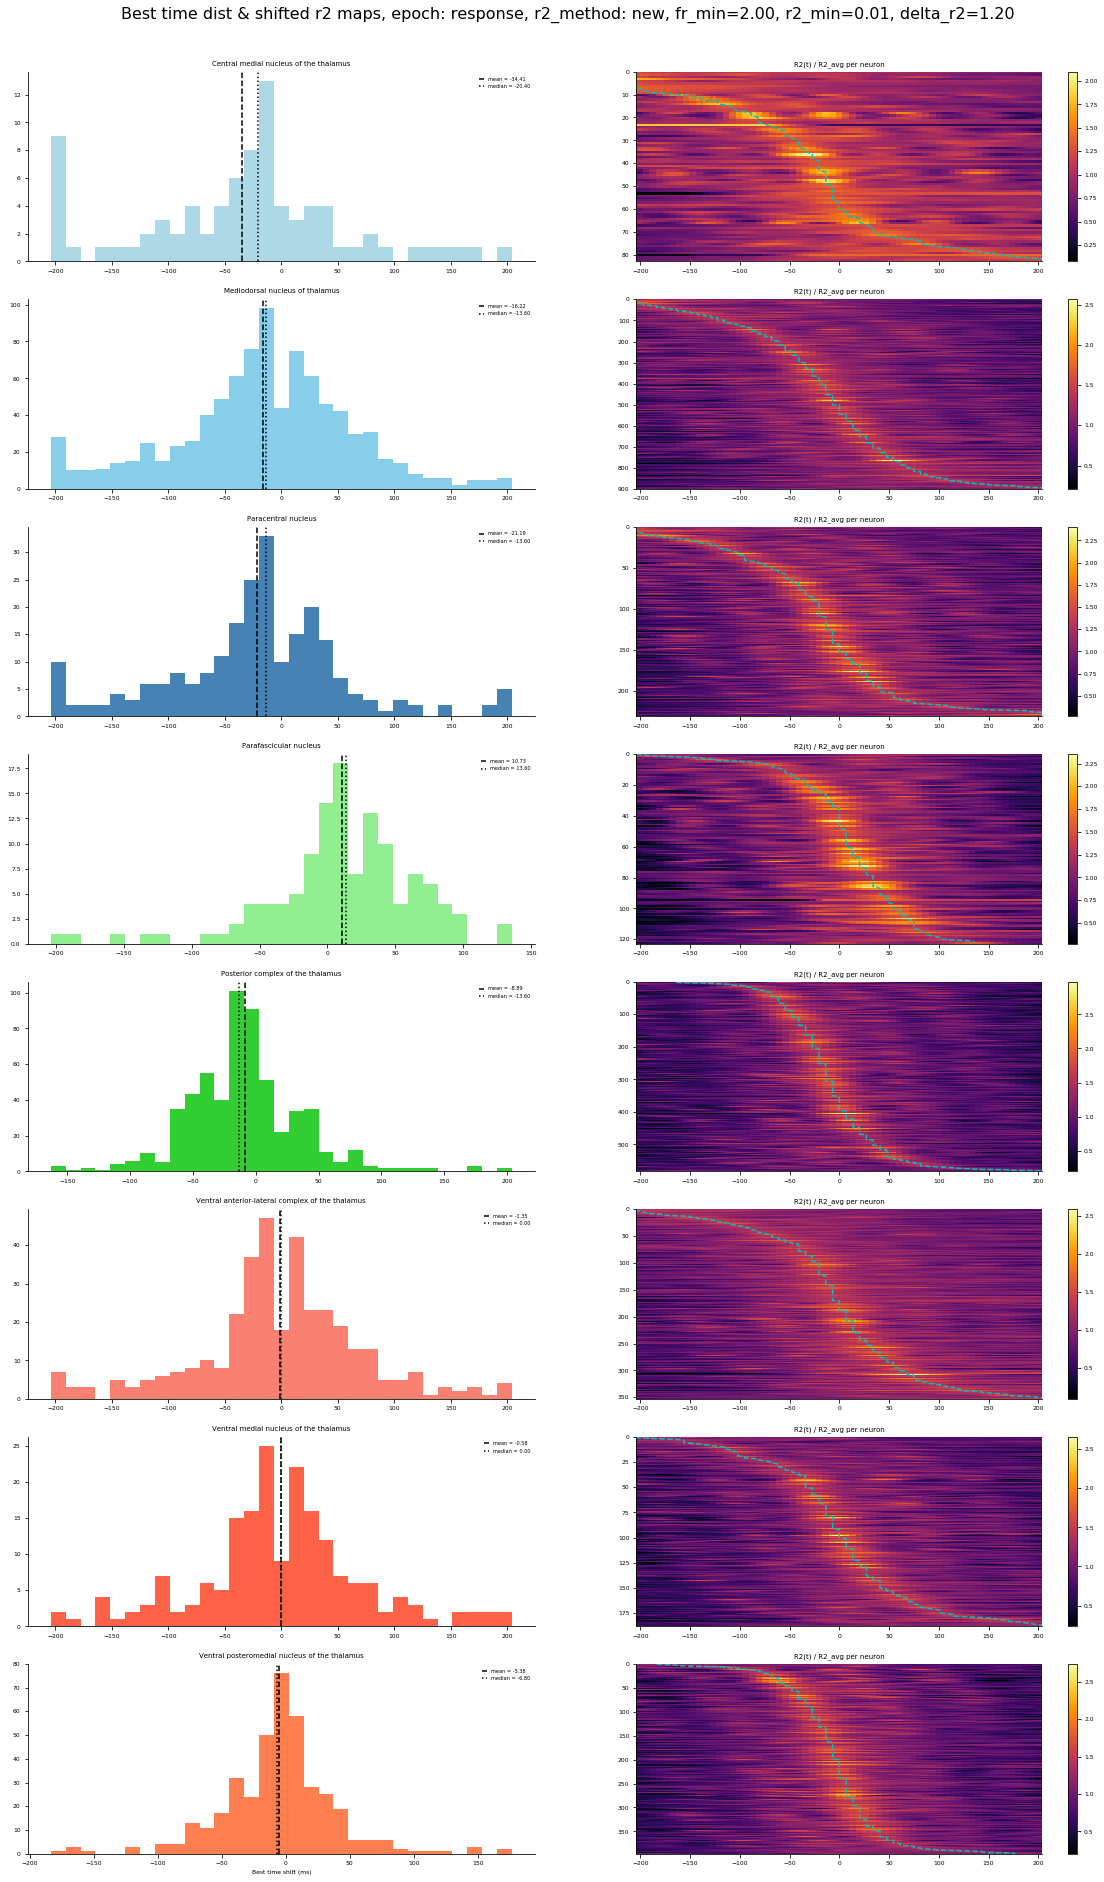

In [7]:
delta_r2 = 1.2

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
#plt.savefig(figfolder + 'thalamus_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

In [8]:
use_cortex_list = ['ALM',
                   'Somatosensory areas',
                   'Somatomotor areas',
                   'Auditory areas',
                   'Orbital area',
                   'Agranular insular area',
                   'Retrosplenial area',]

col_list = [
    "lightblue",    # Some kind of blue
    "skyblue",      # Some kind of blue
    "steelblue",    # Some kind of blue
    "lightgreen",   # Some kind of green
    "limegreen",    # Some kind of green
    "salmon",
    "tomato",
    "coral"
]

short_cortex_names = [
    'ALM',
    'Somatosensory',
    'Somatomotor',
    'Auditory',
    'Orbital',
    'Angular',
    'Retrosplenial',
]

In [9]:
region_list = use_cortex_list
n_min = 100

inds = func.get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

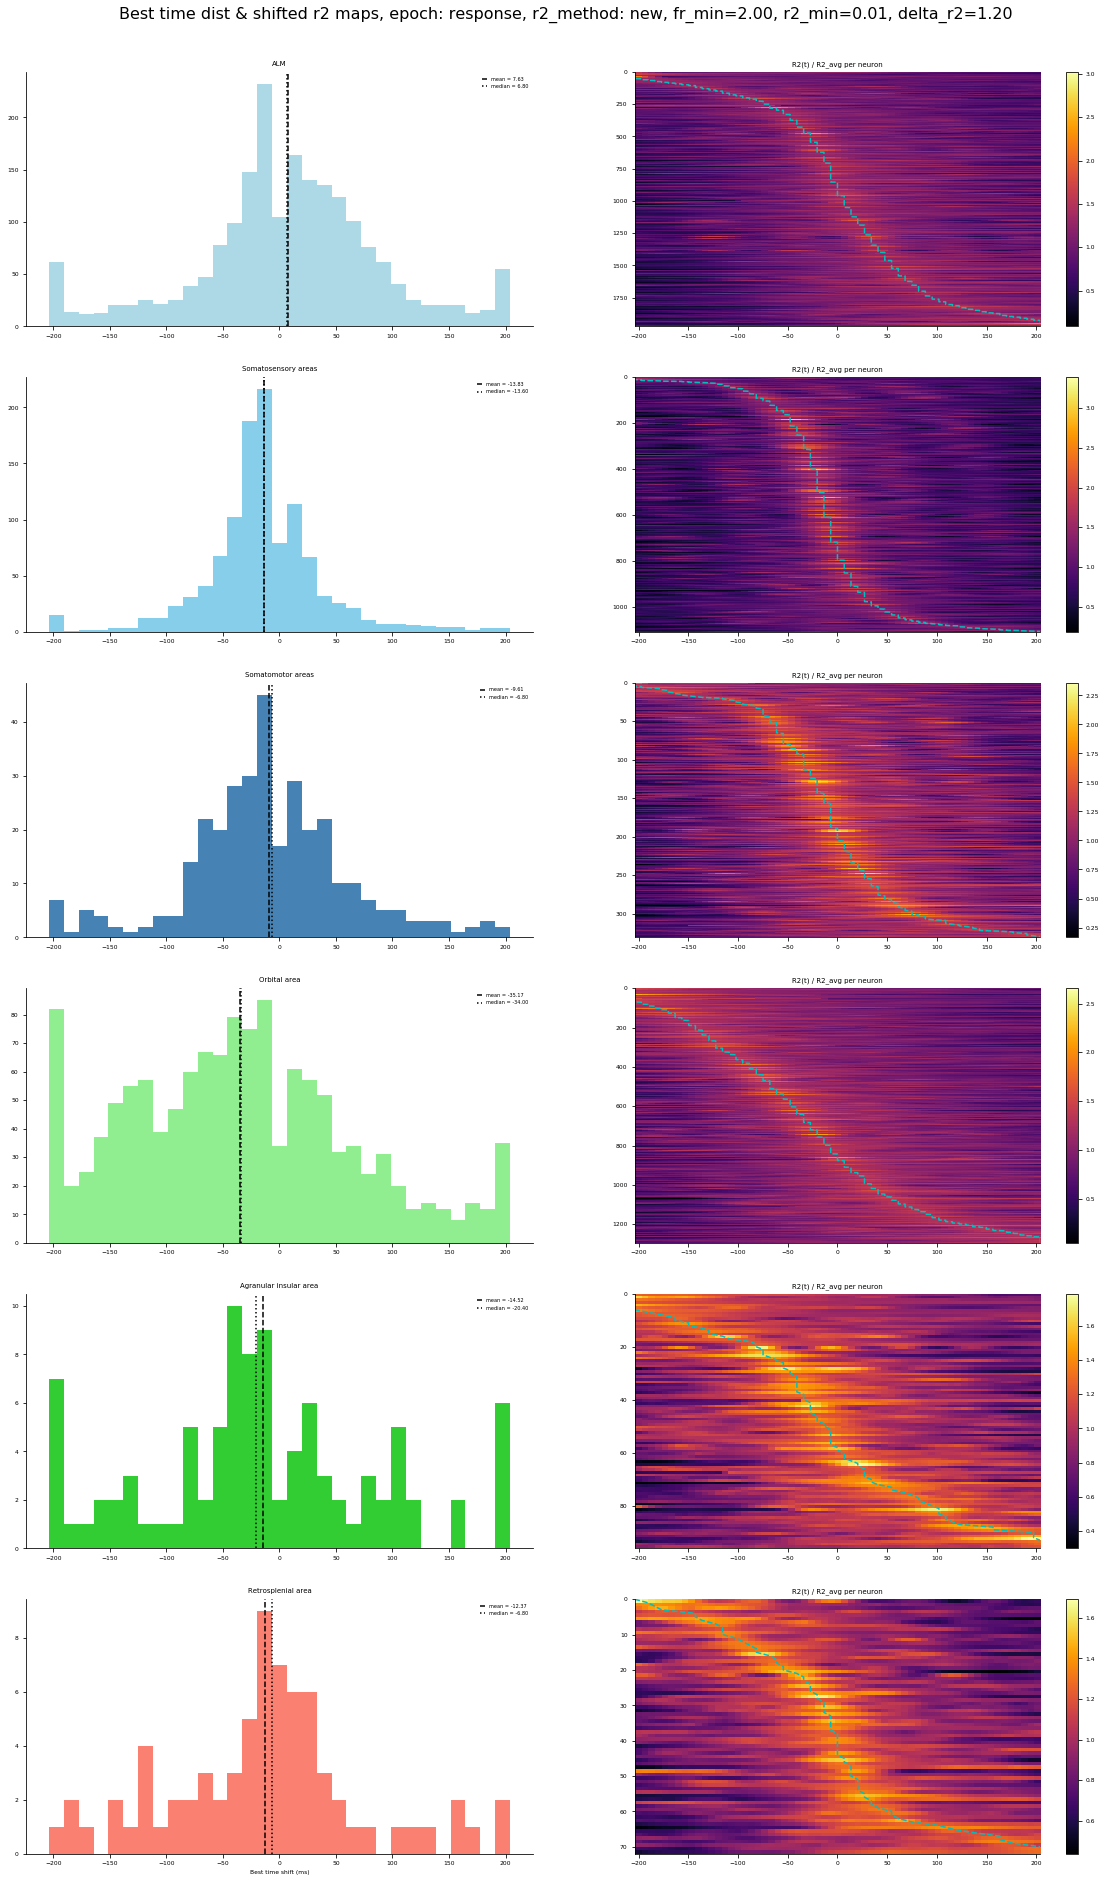

In [10]:
delta_r2 = 1.2

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
#plt.savefig(figfolder + 'cortex_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

In [11]:
medulla_use_nuclei = [
    'Medulla, sensory related',
    'Gigantocellular reticular nucleus',
    'Intermediate reticular nucleus',
    'Magnocellular reticular nucleus',
    'Parvicellular reticular nucleus',
    'Vestibular nuclei',
]

medulla_short_names = [
    'Sensory medulla',
    'Gigantocellular',
    'Intermediate',
    'Magnocellular',
    'Parvicellular',
    'Vestibular'
]

In [12]:
region_list = medulla_use_nuclei
n_min = 100

inds = func.get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}

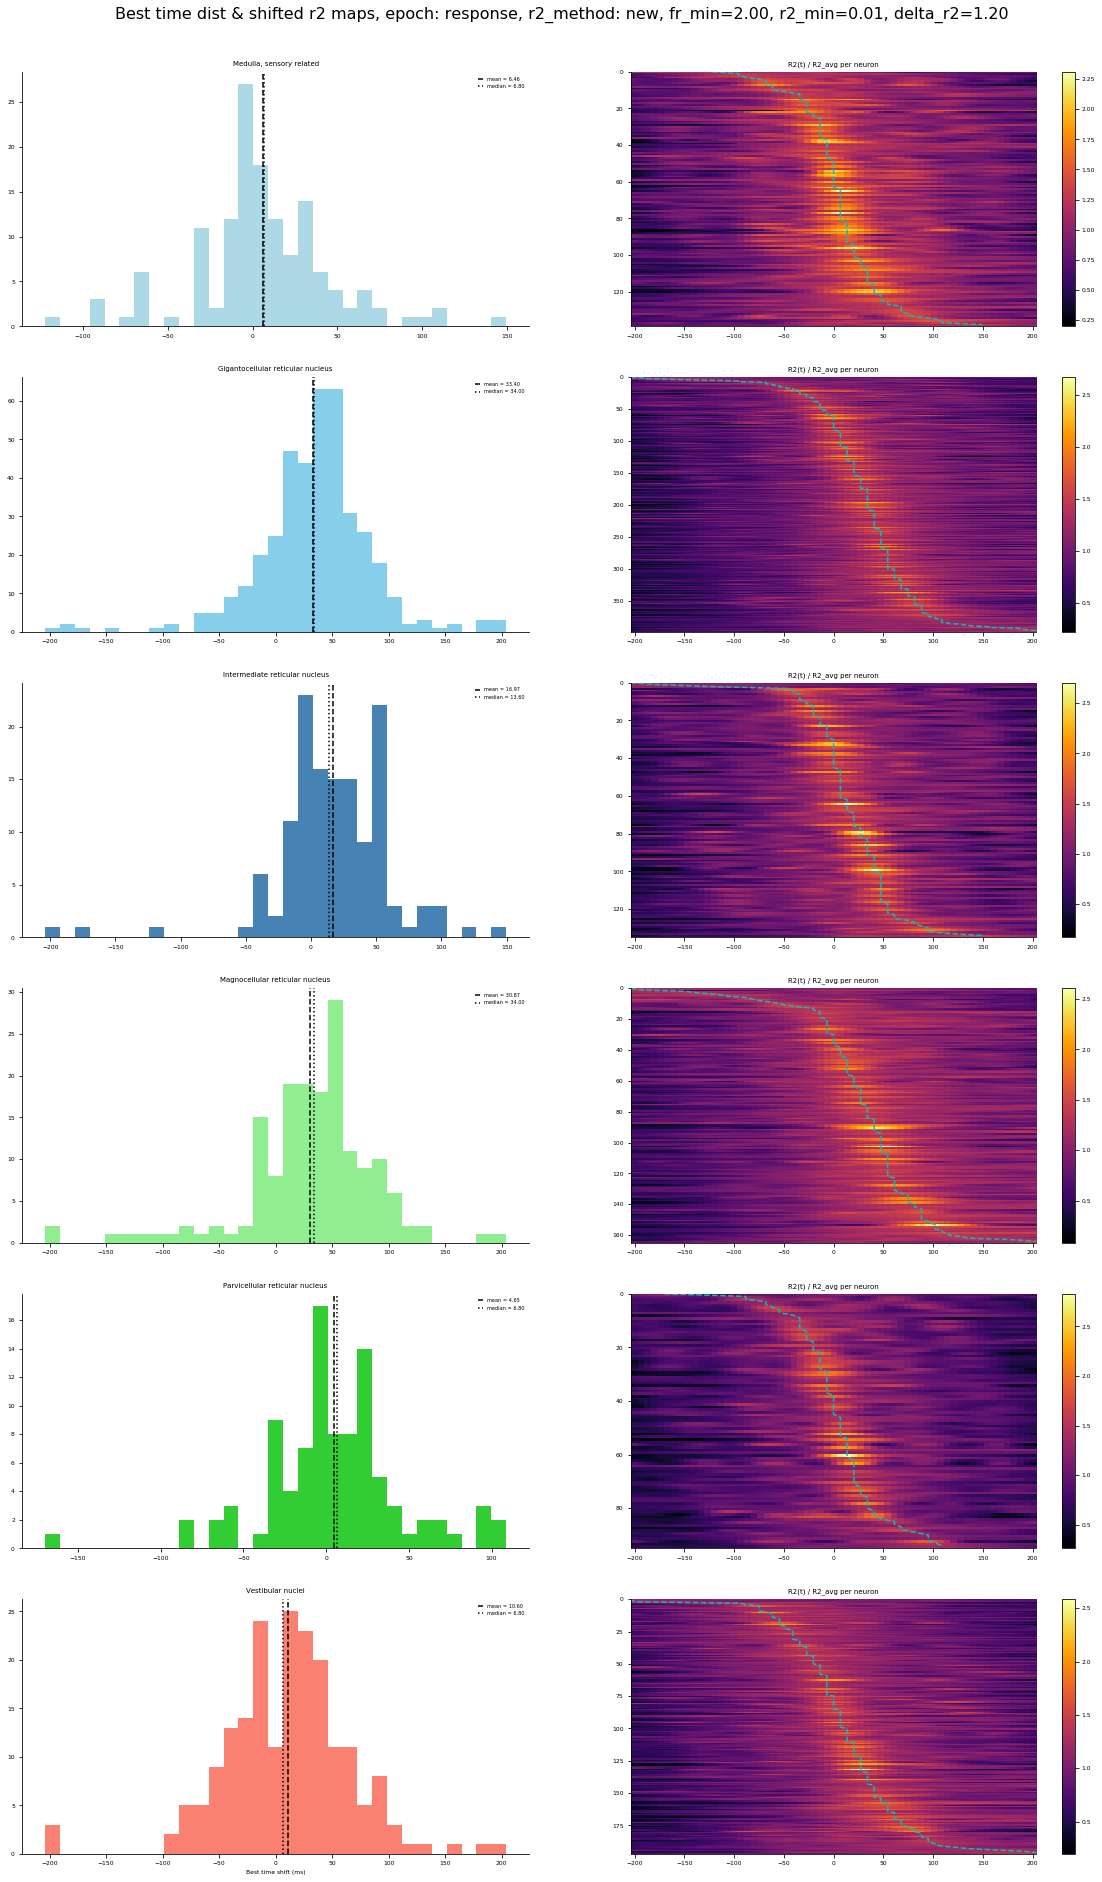

In [13]:
delta_r2 = 1.2

delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]

f,_ = plt.subplots(len(list(use_inds.keys())),2, figsize = (20,30))
f.suptitle('Best time dist & shifted r2 maps, epoch: %s, r2_method: %s, fr_min=%.2f, r2_min=%.2f, delta_r2=%.2f'%(epoch,r2_method,fr_threshold,r2_threshold,delta_r2), fontsize = 16)
for i, area in enumerate(use_inds.keys()):
    _this_inds = np.intersect1d(use_inds[area], delta_inds)
    plt.subplot(len(list(use_inds.keys())),2,2*i+1)
    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = 31, color = cc[i])
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.title(area)
    plt.legend()
    if i == len(list(use_inds.keys()))-1: plt.xlabel('Best time shift (ms)')

    plt.subplot(len(list(use_inds.keys())),2,2*i+2)
    _area_shifted_r2 = r2[:,_this_inds]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)
    plt.title('R2(t) / R2_avg per neuron')

    plt.imshow((_area_shifted_r2[:,_area_sortinds] /_area_shifted_r2[:,_area_sortinds].mean(axis=0, keepdims = True) ).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

plt.subplots_adjust(top = .95)
#plt.savefig(figfolder + 'medulla_best_time_dist_and_r2_maps_%s_%s_frmin%.2f_r2min%.2f.png'%(epoch,r2_method,fr_threshold,r2_threshold), bbox_inches = 'tight')

# Multipanel fig

In [ ]:
import VideoAnalysisUtils.plotting_utils as utils
f7 = utils.Figure7()

In [5]:
f7.load_data()
thalamus_inds,_ = f7.get_thalamus_inds(n_threshold = 50, fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 1.2)
cortex_inds,_ = f7.get_cortex_inds(n_threshold = 100)
medulla_inds,_ = f7.get_medulla_inds(n_threshold = 50)
midbrain_inds,_ = f7.get_midbrain_inds(n_threshold = 50)
best_times = f7.get_best_timeshift()

In [6]:
best_times.shape

(41284,)

In [7]:
n_plots = len(thalamus_inds.keys()) + len(medulla_inds.keys()) + len(midbrain_inds.keys())
n_plots

17

In [8]:
r2_keepfolds = pickle.load(open('../data/r2_embed_cv_timeshift_keepfolds.pkl', 'rb'))
timeshifts = np.arange(-30,32,2, dtype = int)
datafolder = '../data/'
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)
epoch = 'response'

r2 = []
fr = r2_keepfolds['5_0']['%s_fr'%epoch].copy()
ccf_coords = r2_keepfolds['5_0']['ccf_coords'].copy()
ccf_labels = r2_keepfolds['5_0']['ccf_labels'].copy()
alm_inds = np.where(r2_keepfolds['5_0']['is_alm'] == True)[0]

for timesh in timeshifts:
    r2.append(r2_keepfolds['5_%d'%timesh]['%s_r2'%epoch].copy())

r2 = np.array(r2)
best_times_folds = 3.4 * timeshifts[r2.argmax(axis = 0)]
best_times = 3.4 * timeshifts[np.argmax(r2.mean(axis = 2), axis = 0)]

In [9]:
r2.shape

(31, 41284, 5)

In [10]:
def get_filtered_inds(region_list, df, ccf_labels, alm_inds, threshold_inds, n_min = 100):
    inds = func.get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
    use_inds = {k: np.intersect1d(v,threshold_inds) for k,v in inds.items() if np.intersect1d(v,threshold_inds).shape[0] > n_min}
    return use_inds

def get_threshold_inds(r2, fr, r2_threshold = 0.01, fr_threshold = 2.0, delta_r2 = 1.2):
    delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
    threshold_inds = np.intersect1d(threshold_inds, delta_inds)
    return threshold_inds

In [11]:
fr_threshold = 2
r2_threshold = 0.01
delta_r2 = 1.2
n_threshold = 50

areas_of_interest = ['Somatosensory areas','ALM', 
                     'Posterior complex of the thalamus', 'Ventral medial nucleus of the thalamus', 
                     'Medulla, sensory related', 'Gigantocellular reticular nucleus', 
                     'Pretectal region', 'Superior colliculus, motor related']


fr = r2_keepfolds['5_0']['avg_fr'].copy()
r2_singlefold = r2.mean(axis = -1)

threshold_inds = get_threshold_inds(r2_singlefold, fr, r2_threshold = r2_threshold, fr_threshold = fr_threshold, delta_r2 = delta_r2)
inds_dict = get_filtered_inds(areas_of_interest, df, ccf_labels, alm_inds, threshold_inds, n_min = n_threshold)

In [12]:
alm_inds = inds_dict['ALM']

alm_r2 = r2[:,alm_inds,:]
alm_best_times = best_times[alm_inds]
alm_best_times_folds = best_times_folds[alm_inds]

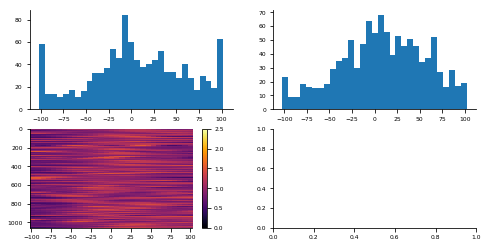

In [13]:
plt.subplots(2,2, figsize = (8,4))

plt.subplot(2,2,1)
plt.hist(alm_best_times, bins = 31)

plt.subplot(2,2,2)
plt.hist(alm_best_times_folds.mean(axis=1), bins = 31)

plt.subplot(2,2,3)
plt.imshow(alm_r2.mean(axis = -1).T/alm_r2.mean(axis = (-1)).mean(axis = 0, keepdims = True).T, aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, alm_r2.shape[1], 0], vmin = 0, vmax = 2.5)
plt.colorbar()

In [14]:
t0_r2 = alm_r2[np.where(timeshifts == 0)[0][0],:,:]
best_time_r2 = np.array([alm_r2[t,i, :] for i,t in enumerate(np.argmax(alm_r2.mean(axis = -1), axis = 0))])

In [15]:
np.argmax(alm_r2.mean(axis = -1), axis = 0)

array([17, 22, 20, ..., 14, 15, 14])

In [16]:
best_time_r2.shape

(1059, 5)

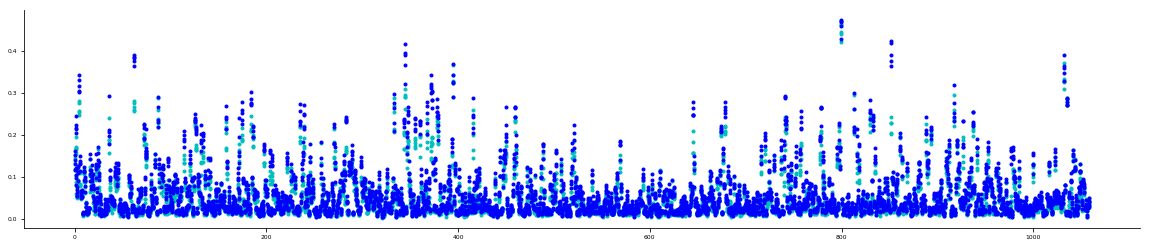

In [17]:
plt.figure(figsize = (20,4))
plt.plot(np.arange(alm_best_times.shape[0]), t0_r2,'c.')
plt.plot(np.arange(alm_best_times.shape[0]), best_time_r2,'b.')

In [18]:
p_values_relttest = np.array([stats.ttest_rel(t0_r2[i,:], best_time_r2[i,:])[1] for i in range(t0_r2.shape[0])])
p_values_indttest = np.array([stats.ttest_ind(t0_r2[i,:], best_time_r2[i,:])[1] for i in range(t0_r2.shape[0])])
p_values_wilcoxon = np.array([stats.mannwhitneyu(t0_r2[i,:], best_time_r2[i,:])[1] for i in range(t0_r2.shape[0])])
p_values_besttimes_t = np.array([stats.ttest_1samp(alm_best_times_folds[i,:], 0)[1] for i in range(alm_best_times_folds.shape[0])])
p_values_besttimes_u = np.array([stats.wilcoxon(alm_best_times_folds[i,:],zero_method = 'zsplit')[1] for i in range(alm_best_times_folds.shape[0])])

/home/kurgyis/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/kurgyis/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


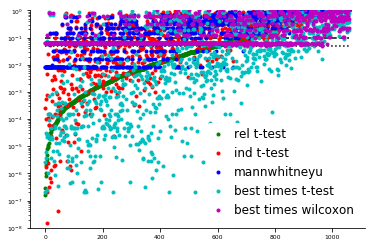

In [19]:
sortinds = np.argsort(p_values_relttest)

plt.plot(p_values_relttest[sortinds], 'g.', label = 'rel t-test')
plt.plot(p_values_indttest[sortinds], 'r.', label = 'ind t-test')
plt.plot(p_values_wilcoxon[sortinds], 'b.', label = 'mannwhitneyu')
plt.plot(p_values_besttimes_t[sortinds], 'c.', label = 'best times t-test')
plt.plot(p_values_besttimes_u[sortinds], 'm.', label = 'best times wilcoxon')
plt.hlines(0.1, 0, p_values_relttest.shape[0], 'k', 'dashed')
plt.hlines(0.05, 0, p_values_relttest.shape[0], 'k', 'dotted')
plt.yscale('log')
plt.ylim(1e-8,1)
plt.legend(fontsize = 12)

In [18]:
def get_false_discovery_rate_significant_inds(p_values, q = 0.1):
    n_tests = p_values.shape[0]
    sort_inds = np.argsort(p_values)
    significance_mask = p_values[sort_inds] < q * np.arange(1,n_tests+1) / n_tests
    significant_inds = sort_inds[significance_mask]
    return significant_inds

In [19]:
def plot_timeshift_histogram(ax,area_best_times, area_name, color = 'blue', zero_line = True, print_label = True):
    ax.hist(area_best_times, bins = np.linspace(-105.4,105.4,32), color = color, alpha = 0.9)
    mean = area_best_times.mean()
    sem = stats.sem(area_best_times)
    a,b = ax.get_ylim()
    if zero_line: ax.plot([0,0], [0,1.1*b], ':', color = 'black',)
    ax.plot([mean, mean], [0,1.1*b], 'w--',  lw = 2 ,label = r'$\tau = %.1f \pm %.1f$ ms'%(mean,sem))
    if print_label:
        print('%s, tau = %.1f +/- %.1f ms'%(area_name,mean,sem))
    
    ax.set_ylim(0,1.1*b)
    ax.set_title('%s, n=%d'%(area_name,len(area_best_times)))
    ax.set_xlabel('Best time shift (ms)')
    ax.set_ylabel('Number of neurons')
    ax.legend()

In [22]:
for p_values in [p_values_relttest, p_values_indttest, p_values_wilcoxon, p_values_besttimes_t, p_values_besttimes_u]:
    significant_inds = get_false_discovery_rate_significant_inds(p_values, q = 0.1)
    print(significant_inds.shape)

significant_inds = get_false_discovery_rate_significant_inds(p_values_relttest, q = 0.05)

len(significant_inds)

significant_mask = np.zeros(p_values_relttest.shape[0], dtype = bool)
significant_mask[significant_inds] = True


(617,)
(217,)
(78,)
(648,)
(0,)


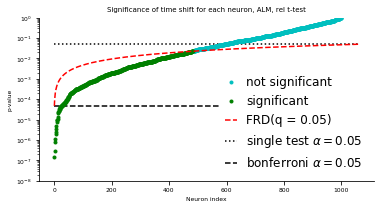

In [23]:
plt.figure(figsize = (6,3))
sortinds = np.argsort(p_values_relttest)

sorted_mask = significant_mask[sortinds]

n_test = len(sortinds)
plt.plot(np.arange(1,n_test+1)[sorted_mask!=1],p_values_relttest[sortinds][sorted_mask!=1], 'c.', label = 'not significant')
plt.plot(np.arange(1,n_test+1)[sorted_mask==1],p_values_relttest[sortinds][sorted_mask==1], 'g.', label = 'significant')
plt.plot(np.arange(1,n_test+1), 0.05 * np.arange(1,n_test+1) / n_test, 'r--', label = 'FRD(q = 0.05)')

#plt.hlines(0.1, 0, p_values_relttest.shape[0], 'k', 'dashed')
plt.hlines(0.05, 0, p_values_relttest.shape[0], 'k', 'dotted', label = r'single test $\alpha = 0.05$')
plt.hlines(0.05 / n_test, 0, p_values_relttest.shape[0], 'k', 'dashed', label = r'bonferroni $\alpha = 0.05$')
plt.yscale('log')
plt.ylim(1e-8,1)
plt.legend(fontsize = 12)
plt.xlabel('Neuron index')
plt.ylabel('p-value')

plt.title('Significance of time shift for each neuron, ALM, rel t-test')
plt.savefig('../figs/supplementary_figs/' + 'alm_time_shift_significance.png', bbox_inches = 'tight', dpi = 300)

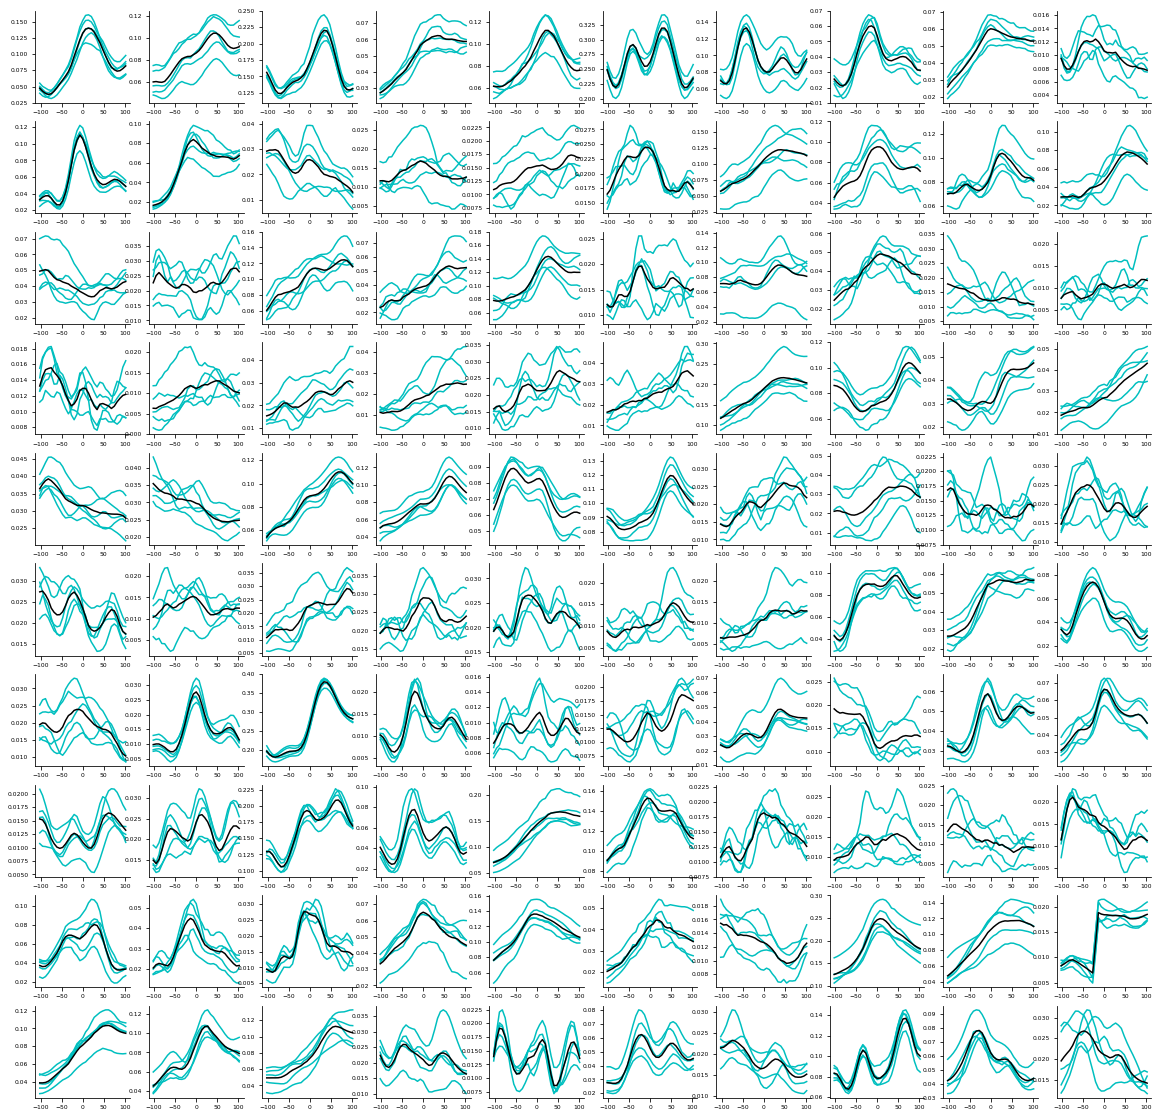

In [24]:
plt.subplots(10,10, figsize = (20,20))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.plot(3.4*timeshifts,r2[:,alm_inds[i],:],'c-')
    plt.plot(3.4*timeshifts,r2_singlefold[:,alm_inds[i]], 'k-')

(array([33.,  7.,  6.,  8.,  7., 12.,  7.,  9., 15., 17., 19., 21., 19.,
        16., 13.,  0.,  4., 11., 17., 21., 33., 19., 17., 18., 27., 20.,
         9., 18.,  8., 14., 37.]),
 array([-102.        ,  -95.41935484,  -88.83870968,  -82.25806452,
         -75.67741935,  -69.09677419,  -62.51612903,  -55.93548387,
         -49.35483871,  -42.77419355,  -36.19354839,  -29.61290323,
         -23.03225806,  -16.4516129 ,   -9.87096774,   -3.29032258,
           3.29032258,    9.87096774,   16.4516129 ,   23.03225806,
          29.61290323,   36.19354839,   42.77419355,   49.35483871,
          55.93548387,   62.51612903,   69.09677419,   75.67741935,
          82.25806452,   88.83870968,   95.41935484,  102.        ]),
 <a list of 31 Patch objects>)

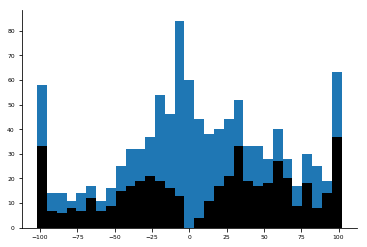

In [25]:
plt.hist(alm_best_times, bins = 31)
plt.hist(alm_best_times[significant_inds], bins = 31, color = 'k')

### Move to area pair comparisons

Text(0.5,1,'Ventral medial nucleus of the thalamus, n=134')

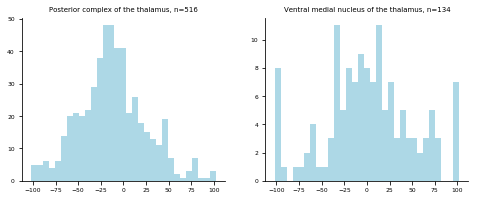

In [ ]:
area1 = 'Posterior complex of the thalamus'
area2 = 'Ventral medial nucleus of the thalamus'

plt.subplots(1,2, figsize = (8,3))
plt.subplot(1,2,1)
plt.hist(best_times[inds_dict[area1]], bins = 31, color = 'lightblue')
plt.title('%s, n=%d'%(area1, inds_dict[area1].shape[0]))

plt.subplot(1,2,2)
plt.hist(best_times[inds_dict[area2]], bins = 31, color = 'lightblue')
plt.title('%s, n=%d'%(area2, inds_dict[area2].shape[0]))


Somatosensory areas, tau = -14.0 +/- 1.3 ms
ALM, tau = 7.1 +/- 1.7 ms
Posterior complex of the thalamus, tau = -12.5 +/- 1.7 ms
Ventral medial nucleus of the thalamus, tau = 1.9 +/- 4.4 ms
Medulla, sensory related, tau = 8.6 +/- 3.2 ms
Gigantocellular reticular nucleus, tau = 33.8 +/- 2.1 ms
Pretectal region, tau = -1.6 +/- 3.2 ms
Superior colliculus, motor related, tau = 19.8 +/- 1.9 ms


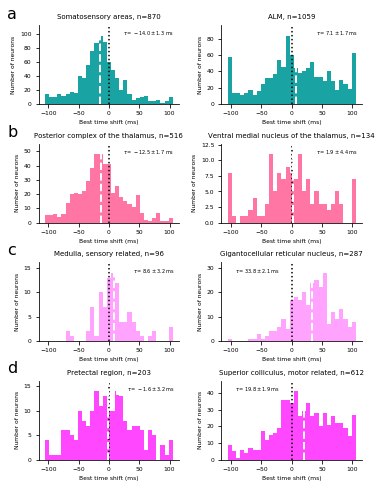

In [20]:
f,axs = plt.subplots(4,2, figsize = (5.8,8))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)

areas_of_interest = ['Somatosensory areas','ALM', 
                     'Posterior complex of the thalamus', 'Ventral medial nucleus of the thalamus', 
                     'Medulla, sensory related', 'Gigantocellular reticular nucleus', 
                     'Pretectal region', 'Superior colliculus, motor related']

colors = [region2color['ALM'], region2color['Thalamus'], region2color['Medulla'], region2color['Midbrain']]

for i in range(8):
    plot_timeshift_histogram(axs[i//2,i%2], best_times[inds_dict[areas_of_interest[i]]], areas_of_interest[i], color = colors[i//2])



for i in range(4):
    f.text(0.05, 0.89 - 0.205 * i, chr(97+i), fontsize = 16)

#plt.savefig(figfolder + 'timeshift_histograms_pairwise_v2.png', bbox_inches = 'tight', dpi = 300)

In [28]:
n_comps = 4

big_areas = [ 'Cortex','Thalamus', 'Medulla', 'Midbrain']

for ii in range(4):
    u,p = stats.mannwhitneyu(best_times[inds_dict[areas_of_interest[2*ii]]], best_times[inds_dict[areas_of_interest[2*ii+1]]])
    print('%s vs %s, p=%.5f'%(areas_of_interest[2*ii],areas_of_interest[2*ii+1],p*n_comps))

Somatosensory areas vs ALM, p=0.00000
Posterior complex of the thalamus vs Ventral medial nucleus of the thalamus, p=0.00194
Medulla, sensory related vs Gigantocellular reticular nucleus, p=0.00000
Pretectal region vs Superior colliculus, motor related, p=0.00000


Somatosensory areas, tau = -12.8 +/- 1.1 ms
ALM, tau = 8.7 +/- 1.5 ms
Posterior complex of the thalamus, tau = -11.6 +/- 1.4 ms
Ventral medial nucleus of the thalamus, tau = 5.8 +/- 3.4 ms
Medulla, sensory related, tau = 7.7 +/- 2.8 ms
Gigantocellular reticular nucleus, tau = 32.6 +/- 1.9 ms
Pretectal region, tau = -0.0 +/- 2.8 ms
Superior colliculus, motor related, tau = 19.3 +/- 1.8 ms


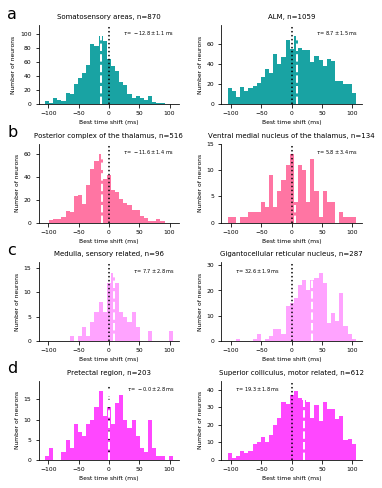

In [29]:
f,axs = plt.subplots(4,2, figsize = (5.8,8))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)

areas_of_interest = ['Somatosensory areas','ALM', 
                     'Posterior complex of the thalamus', 'Ventral medial nucleus of the thalamus', 
                     'Medulla, sensory related', 'Gigantocellular reticular nucleus', 
                     'Pretectal region', 'Superior colliculus, motor related']

colors = [region2color['ALM'], region2color['Thalamus'], region2color['Medulla'], region2color['Midbrain']]

for i in range(8):
    plot_timeshift_histogram(axs[i//2,i%2], best_times_folds[inds_dict[areas_of_interest[i]]].mean(axis = 1), areas_of_interest[i], color = colors[i//2])



for i in range(4):
    f.text(0.05, 0.89 - 0.205 * i, chr(97+i), fontsize = 16)

#plt.savefig(figfolder + 'timeshift_histograms_pairwise_v2.png', bbox_inches = 'tight', dpi = 300)

### Add significance of single-neurons

In [30]:
for ii in range(4):
    u,p = stats.mannwhitneyu(best_times_folds[inds_dict[areas_of_interest[2*ii]]].mean(axis = 1), best_times_folds[inds_dict[areas_of_interest[2*ii+1]]].mean(axis = 1))
    print('%s vs %s, p=%.5f'%(areas_of_interest[2*ii],areas_of_interest[2*ii+1],p*n_comps))

Somatosensory areas vs ALM, p=0.00000
Posterior complex of the thalamus vs Ventral medial nucleus of the thalamus, p=0.00000
Medulla, sensory related vs Gigantocellular reticular nucleus, p=0.00000
Pretectal region vs Superior colliculus, motor related, p=0.00000


In [34]:
colors

[[0, 0.6, 0.6], [1, 0.4, 0.6], [1, 0.6, 1], [1, 0.2, 1]]

In [21]:
def plot_timeshift_histogram_significant(ax,area_best_times, area_name, color = 'blue', zero_line = True, print_label = True, significant_inds = None):
    ax.hist(area_best_times, bins = np.linspace(-105.4,105.4,32), color = color, alpha = 0.8)
    if significant_inds is not None:
        ax.hist(area_best_times[significant_inds], bins = np.linspace(-105.4,105.4,32), color = 'k', alpha = 0.7,)
    mean = area_best_times.mean()
    sem = stats.sem(area_best_times)
    a,b = ax.get_ylim()
    if zero_line: ax.plot([0,0], [0,1.1*b], ':', color = 'black',)
    ax.plot([mean, mean], [0,1.1*b], 'w--',  lw = 2 ,label = r'$\tau = %.1f \pm %.1f$ ms'%(mean,sem))
    if print_label:
        print('%s, tau = %.1f +/- %.1f ms'%(area_name,mean,sem))
    
    ax.set_ylim(0,1.1*b)
    ax.set_title('%s, n=%d'%(area_name,len(area_best_times)))
    ax.set_xlabel('Best time shift (ms)')
    ax.set_ylabel('Number of neurons')
    ax.legend()

In [22]:
def get_significant_inds(r2, best_times_folds, area_inds, q = 0.05, method = 'ttest_rel', timeshifts = np.arange(-30,32,2, dtype = int)):
    area_r2 = r2[:,area_inds,:]
    t0_r2 = area_r2[np.where(timeshifts == 0)[0][0],:,:]
    best_time_r2 = np.array([area_r2[t,i, :] for i,t in enumerate(np.argmax(area_r2.mean(axis = -1), axis = 0))])

    area_best_times_folds = best_times_folds[area_inds]

    if method == 'ttest_rel':
        p_values = np.array([stats.ttest_rel(t0_r2[i,:], best_time_r2[i,:])[1] for i in range(t0_r2.shape[0])])

    elif method == 'besttimes_t':
        p_values = np.array([stats.ttest_1samp(area_best_times_folds[i,:], 0)[1] for i in range(area_best_times_folds.shape[0])])

    significant_inds = get_false_discovery_rate_significant_inds(p_values, q = q)
    return significant_inds

Somatosensory areas, tau = -14.0 +/- 1.3 ms
ALM, tau = 7.1 +/- 1.7 ms
Posterior complex of the thalamus, tau = -12.5 +/- 1.7 ms
Ventral medial nucleus of the thalamus, tau = 1.9 +/- 4.4 ms
Medulla, sensory related, tau = 8.6 +/- 3.2 ms
Gigantocellular reticular nucleus, tau = 33.8 +/- 2.1 ms
Pretectal region, tau = -1.6 +/- 3.2 ms
Superior colliculus, motor related, tau = 19.8 +/- 1.9 ms


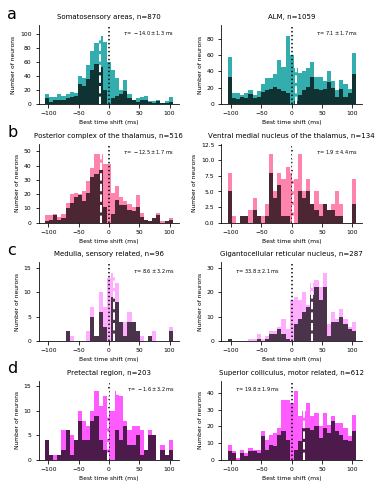

In [48]:
f,axs = plt.subplots(4,2, figsize = (5.8,8))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)

areas_of_interest = ['Somatosensory areas','ALM', 
                     'Posterior complex of the thalamus', 'Ventral medial nucleus of the thalamus', 
                     'Medulla, sensory related', 'Gigantocellular reticular nucleus', 
                     'Pretectal region', 'Superior colliculus, motor related']

colors = [region2color['ALM'], region2color['Thalamus'], region2color['Medulla'], region2color['Midbrain']]

for i in range(8):
    significant_inds = get_significant_inds(r2, best_times_folds, inds_dict[areas_of_interest[i]], q = 0.05, method = 'ttest_rel')
    plot_timeshift_histogram_significant(axs[i//2,i%2], best_times[inds_dict[areas_of_interest[i]]], areas_of_interest[i], color = colors[i//2], significant_inds=significant_inds)


for i in range(4):
    f.text(0.05, 0.89 - 0.205 * i, chr(97+i), fontsize = 16)

plt.savefig(figfolder + 'timeshift_histograms_pairwise_v3.pdf', bbox_inches = 'tight', dpi = 300)

### Old version

Somatosensory areas, tau = -12.8 +/- 1.1 ms
ALM, tau = 8.7 +/- 1.5 ms
Posterior complex of the thalamus, tau = -11.6 +/- 1.4 ms
Ventral medial nucleus of the thalamus, tau = 5.8 +/- 3.4 ms
Medulla, sensory related, tau = 7.7 +/- 2.8 ms
Gigantocellular reticular nucleus, tau = 32.6 +/- 1.9 ms
Pretectal region, tau = -0.0 +/- 2.8 ms
Superior colliculus, motor related, tau = 19.3 +/- 1.8 ms


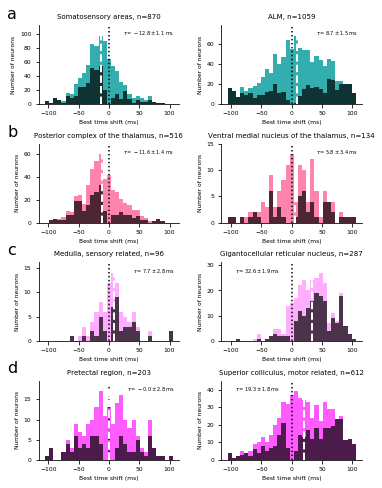

In [33]:
f,axs = plt.subplots(4,2, figsize = (5.8,8))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(8):
    significant_inds = get_significant_inds(r2, best_times_folds, inds_dict[areas_of_interest[i]], q = 0.01, method = 'besttimes_t')
    plot_timeshift_histogram_significant(axs[i//2,i%2], best_times_folds[inds_dict[areas_of_interest[i]]].mean(axis = 1), areas_of_interest[i], color = colors[i//2], significant_inds=significant_inds)

for i in range(4):
    f.text(0.05, 0.89 - 0.205 * i, chr(97+i), fontsize = 16)

#plt.savefig(figfolder + 'timeshift_histograms_pairwise_v4.png', bbox_inches = 'tight', dpi = 300)

### Final version: Exclude medulla

Somatosensory areas, tau = -12.8 +/- 1.1 ms
ALM, tau = 8.7 +/- 1.5 ms
Posterior complex of the thalamus, tau = -11.6 +/- 1.4 ms
Ventral medial nucleus of the thalamus, tau = 5.8 +/- 3.4 ms
Pretectal region, tau = -0.0 +/- 2.8 ms
Superior colliculus, motor related, tau = 19.3 +/- 1.8 ms


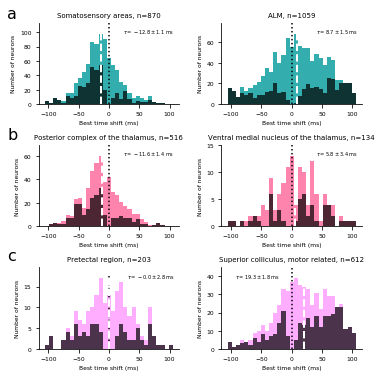

In [27]:
f,axs = plt.subplots(3,2, figsize = (5.8,6))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)
no_medulla_inds = [0,1,2,3,6,7]

for i in range(6):
    ii = no_medulla_inds[i]
    significant_inds = get_significant_inds(r2, best_times_folds, inds_dict[areas_of_interest[ii]], q = 0.01, method = 'besttimes_t')
    plot_timeshift_histogram_significant(axs[i//2,i%2], best_times_folds[inds_dict[areas_of_interest[ii]]].mean(axis = 1), areas_of_interest[ii], color = colors[i//2], significant_inds=significant_inds)

for i in range(3):
    f.text(0.05, 0.89 - 0.28 * i, chr(97+i), fontsize = 16)

plt.savefig(figfolder + 'timeshift_histograms_pairwise_v5.png', bbox_inches = 'tight', dpi = 300)

In [31]:
n_comps = 3
for ii in range(4):
    u,p = stats.mannwhitneyu(best_times_folds[inds_dict[areas_of_interest[2*ii+1]]].mean(axis = 1),best_times_folds[inds_dict[areas_of_interest[2*ii]]].mean(axis = 1), alternative='greater')
    print('%s vs %s, p=%.5f'%(areas_of_interest[2*ii],areas_of_interest[2*ii+1],p*n_comps))

Somatosensory areas vs ALM, p=0.00000
Posterior complex of the thalamus vs Ventral medial nucleus of the thalamus, p=0.00000
Medulla, sensory related vs Gigantocellular reticular nucleus, p=0.00000
Pretectal region vs Superior colliculus, motor related, p=0.00000


In [54]:
fr_threshold = 2
r2_threshold = 0.01
delta_r2 = 1.2
n_threshold = 50

areas_of_interest = ['Somatosensory areas','ALM', 
                     'Posterior complex of the thalamus', 'Ventral medial nucleus of the thalamus', 
                     'Medulla, sensory related', 'Gigantocellular reticular nucleus', 
                     'Pretectal region', 'Superior colliculus, motor related']


fr = r2_keepfolds['5_0']['avg_fr'].copy()
r2_singlefold = r2.mean(axis = -1)

threshold_inds = get_threshold_inds(r2_singlefold, fr, r2_threshold = r2_threshold, fr_threshold = fr_threshold, delta_r2 = delta_r2)
inds_dict = get_filtered_inds(areas_of_interest, df, ccf_labels, alm_inds, threshold_inds, n_min = n_threshold)

Somatosensory areas, tau = -12.8 +/- 1.1 ms
ALM, tau = 8.7 +/- 1.5 ms
Posterior complex of the thalamus, tau = -11.6 +/- 1.4 ms
Ventral medial nucleus of the thalamus, tau = 5.8 +/- 3.4 ms
Pretectal region, tau = -0.0 +/- 2.8 ms
Superior colliculus, motor related, tau = 19.3 +/- 1.8 ms


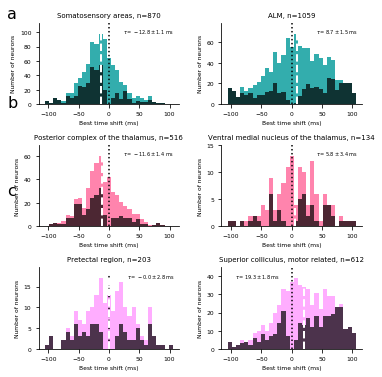

In [55]:
f,axs = plt.subplots(3,2, figsize = (5.8,6))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)
no_medulla_inds = [0,1,2,3,6,7]

for i in range(6):
    ii = no_medulla_inds[i]
    significant_inds = get_significant_inds(r2, best_times_folds, inds_dict[areas_of_interest[ii]], q = 0.01, method = 'besttimes_t')
    plot_timeshift_histogram_significant(axs[i//2,i%2], best_times_folds[inds_dict[areas_of_interest[ii]]].mean(axis = 1), areas_of_interest[ii], color = colors[i//2], significant_inds=significant_inds)

for i in range(3):
    f.text(0.05, 0.89 - 0.205 * i, chr(97+i), fontsize = 16)

#plt.savefig(figfolder + 'timeshift_histograms_pairwise_v5.pdf', bbox_inches = 'tight', dpi = 300)

### Old versions

#### V1

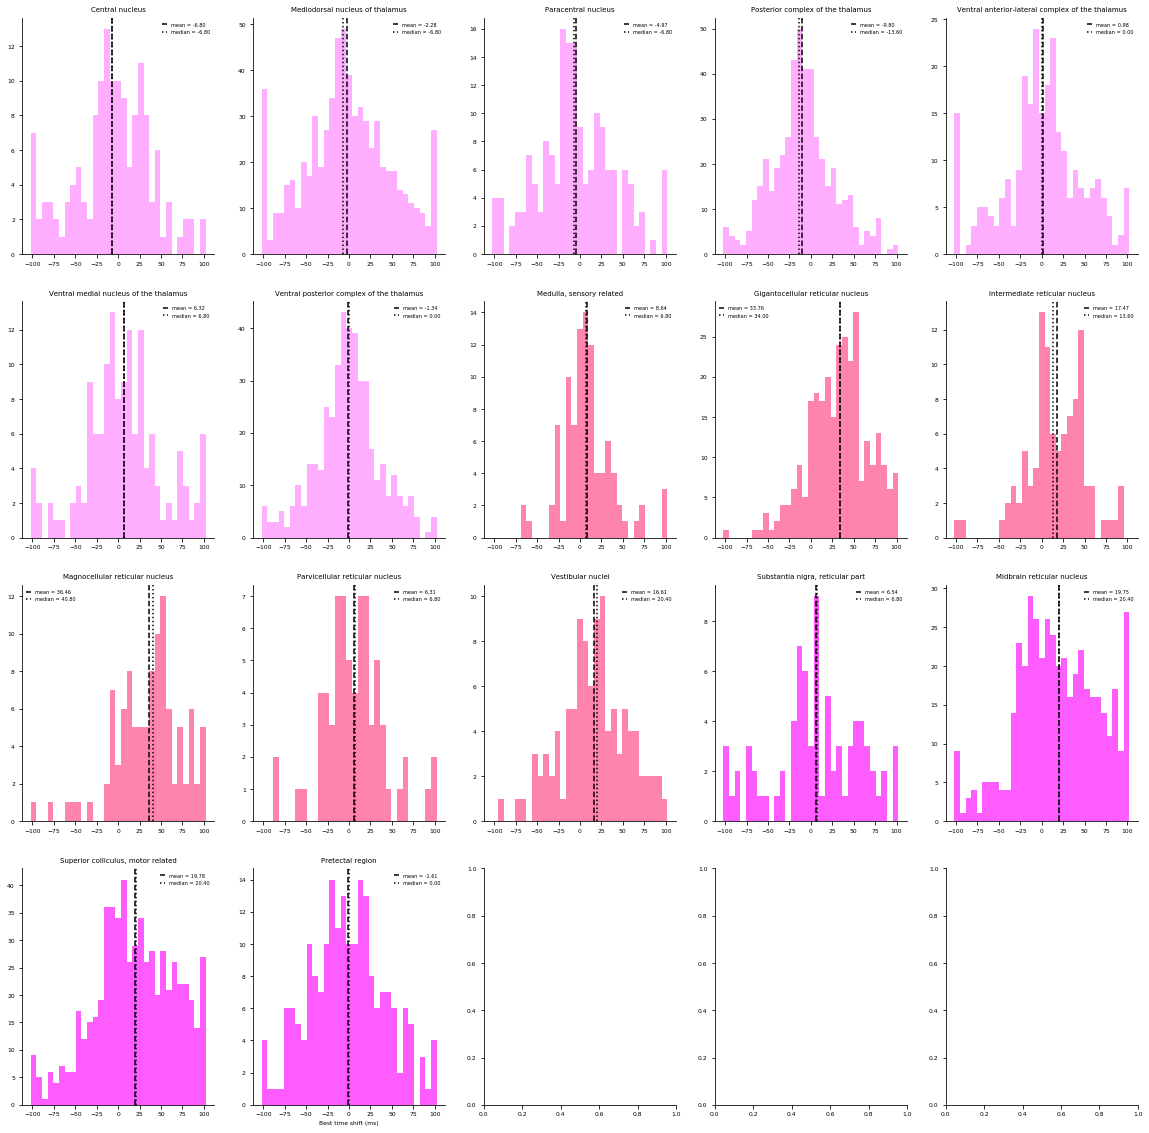

In [18]:
plt.subplots(4,5, figsize = (20,20))
for i_plot in range(n_plots):
    plt.subplot(4,5,i_plot+1)
    if i_plot < len(thalamus_inds.keys()):
        area = list(thalamus_inds.keys())[i_plot]
        _this_inds = thalamus_inds[area]
        plt.title(area)
        col = region2color['Medulla']
    elif i_plot < len(thalamus_inds.keys()) + len(medulla_inds.keys()):
        area = list(medulla_inds.keys())[i_plot - len(thalamus_inds.keys())]
        _this_inds = medulla_inds[area]
        plt.title(area)
        col = region2color['Thalamus']
    else:
        area = list(midbrain_inds.keys())[i_plot - len(thalamus_inds.keys()) - len(medulla_inds.keys())]
        _this_inds = midbrain_inds[area]
        plt.title(area)
        col = region2color['Midbrain']

    _mean = best_times[_this_inds].mean()
    _meadian = np.median(best_times[_this_inds])
    plt.hist(best_times[_this_inds], bins = np.linspace(-102,102,32), color = col, alpha = 0.8)
    a,b = plt.ylim()
    plt.plot([_mean, _mean], [a,b], 'k--', label = 'mean = %.2f'%_mean)
    plt.plot([_meadian, _meadian], [a,b], 'k:', label = 'median = %.2f'%_meadian)
    plt.ylim(a,b)
    plt.legend()
    if i_plot == n_plots-1: plt.xlabel('Best time shift (ms)')
plt.savefig(figfolder + 'timeshift_histgorams.png', bbox_inches = 'tight', dpi = 300)

#### V2

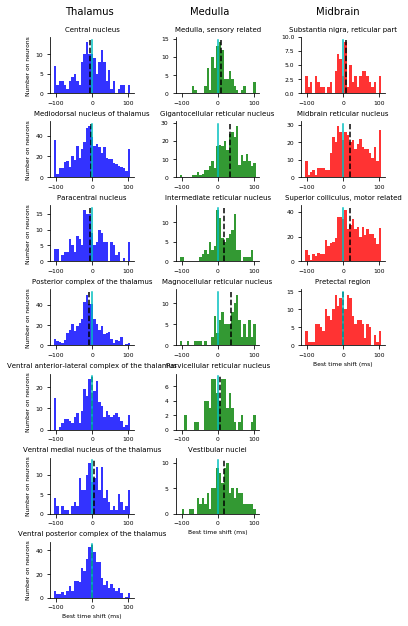

In [19]:
plt.rcParams['figure.figsize'][1] = style.fig_w_max * 12 / 9
plt.subplots(7,3)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
plt.subplots_adjust(top = 0.95)

filter_extreme_from_mean = True
plot_zero_line = True

extreme_inds = np.where((np.abs(best_times) > -100))[0]

for i_thalamus in range(len(thalamus_inds.keys())):
    plt.subplot(7,3, 3 * i_thalamus + 1)
    area = list(thalamus_inds.keys())[i_thalamus]
    _this_inds = thalamus_inds[area]
    plt.title(area)
    
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'blue', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.intersect1d(_this_inds, extreme_inds)
        mean = best_times[mean_inds].mean()
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    #plt.legend()
    plt.ylabel('Number on neurons')
    if i_thalamus == len(thalamus_inds.keys()) -1: plt.xlabel('Best time shift (ms)')
    if i_thalamus == 0:
        plt.text(plt.xlim()[0] + 40, plt.ylim()[1]*1.4, 'Thalamus')

for i_medulla in range(len(medulla_inds.keys())):
    plt.subplot(7,3, 3 * i_medulla + 2)
    area = list(medulla_inds.keys())[i_medulla]
    _this_inds = medulla_inds[area]
    plt.title(area)
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'green', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.intersect1d(_this_inds, extreme_inds)
        mean = best_times[mean_inds].mean()
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    #plt.ylabel('Number on neurons')
    if i_medulla == len(medulla_inds.keys())-1: plt.xlabel('Best time shift (ms)')
    if i_medulla == 0:
        plt.text(plt.xlim()[0] + 40, plt.ylim()[1]*1.4, 'Medulla')

for ii in range(len(medulla_inds.keys()),7):
    plt.subplot(7,3, 3 * ii + 2)
    plt.axis('off')

for i_midbrain in range(len(midbrain_inds.keys())):
    plt.subplot(7,3, 3 * i_midbrain + 3)
    area = list(midbrain_inds.keys())[i_midbrain]
    _this_inds = midbrain_inds[area]
    plt.title(area)
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'red', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.intersect1d(_this_inds, extreme_inds)
        mean = best_times[mean_inds].mean()
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    #plt.ylabel('Number on neurons')
    if i_midbrain == len(midbrain_inds.keys()) - 1: plt.xlabel('Best time shift (ms)')
    if i_midbrain == 0:
        plt.text(plt.xlim()[0] + 40, plt.ylim()[1]*1.4, 'Midbrain')

for ii in range(len(midbrain_inds.keys()),7):
    plt.subplot(7,3, 3 * ii + 3)
    plt.axis('off')

plt.savefig(figfolder + 'timeshift_histgorams.png', bbox_inches = 'tight', dpi = 300)


#### V3

In [20]:
print(thalamus_inds.keys())
print(medulla_inds.keys())
print(midbrain_inds.keys())

dict_keys(['Central nucleus', 'Mediodorsal nucleus of thalamus', 'Paracentral nucleus', 'Posterior complex of the thalamus', 'Ventral anterior-lateral complex of the thalamus', 'Ventral medial nucleus of the thalamus', 'Ventral posterior complex of the thalamus'])
dict_keys(['Medulla, sensory related', 'Gigantocellular reticular nucleus', 'Intermediate reticular nucleus', 'Magnocellular reticular nucleus', 'Parvicellular reticular nucleus', 'Vestibular nuclei'])
dict_keys(['Substantia nigra, reticular part', 'Midbrain reticular nucleus', 'Superior colliculus, motor related', 'Pretectal region'])


In [7]:
short_name_dict = {
    # Thalamus regions
    'Central nucleus': 'CN',
    'Mediodorsal nucleus of thalamus': 'MD',
    'Paracentral nucleus': 'PC',
    'Posterior complex of the thalamus': 'PO',
    'Ventral anterior-lateral complex of the thalamus': 'VAL',
    'Ventral medial nucleus of the thalamus': 'VM',
    'Ventral posterior complex of the thalamus': 'VP',

    # Medulla and reticular nuclei regions
    'Medulla, sensory related': 'MSR',
    'Gigantocellular reticular nucleus': 'GRN',
    'Intermediate reticular nucleus': 'IRN',
    'Magnocellular reticular nucleus': 'MRN',
    'Parvicellular reticular nucleus': 'PRN',
    'Vestibular nuclei': 'VN',

    # Midbrain and superior colliculus regions
    'Substantia nigra, reticular part': 'SNr',
    'Midbrain reticular nucleus': 'MRN',
    'Superior colliculus, motor related': 'SCm',
    'Pretectal region': 'PT'
}


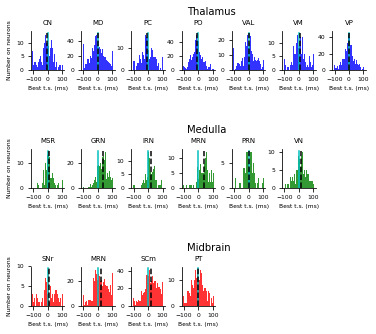

In [22]:
plt.rcParams['figure.figsize'][1] = style.fig_w_max * 5 / 7
plt.subplots(5,7)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
#plt.subplots_adjust(top = 0.95)

filter_extreme_from_mean = True
plot_zero_line = True

extreme_inds = np.where((np.abs(best_times) > -100))[0]

for i_thalamus in range(len(thalamus_inds.keys())):
    plt.subplot(5,7, i_thalamus + 1)
    area = list(thalamus_inds.keys())[i_thalamus]
    _this_inds = thalamus_inds[area]
    plt.title(short_name_dict[area])
    
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'blue', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.intersect1d(_this_inds, extreme_inds)
        mean = best_times[mean_inds].mean()
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.legend()
    if i_thalamus == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best t.s. (ms)')
    if i_thalamus == 3:
        plt.text(plt.xlim()[0] + 40, plt.ylim()[1]*1.4, 'Thalamus')

for i_medulla in range(len(medulla_inds.keys())):
    plt.subplot(5,7, 14 +  i_medulla + 1)
    area = list(medulla_inds.keys())[i_medulla]
    _this_inds = medulla_inds[area]
    plt.title(short_name_dict[area])
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'green', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.intersect1d(_this_inds, extreme_inds)
        mean = best_times[mean_inds].mean()
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.ylabel('Number on neurons')
    if i_medulla == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best t.s. (ms)')
    if i_medulla == 3:
        plt.text(plt.xlim()[0] + 40, plt.ylim()[1]*1.4, 'Medulla')

for ii in range(len(medulla_inds.keys()),7):
    plt.subplot(5,7, 14 + ii + 1)
    plt.axis('off')

for i_midbrain in range(len(midbrain_inds.keys())):
    plt.subplot(5,7, 28 + i_midbrain + 1)
    area = list(midbrain_inds.keys())[i_midbrain]
    _this_inds = midbrain_inds[area]
    plt.title(short_name_dict[area])
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'red', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.intersect1d(_this_inds, extreme_inds)
        mean = best_times[mean_inds].mean()
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.ylabel('Number on neurons')
    if i_midbrain == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best t.s. (ms)')
    if i_midbrain == 3:
        plt.text(plt.xlim()[0] + 40, plt.ylim()[1]*1.4, 'Midbrain')

for ii in range(len(midbrain_inds.keys()),7):
    plt.subplot(5,7, 28 + ii + 1)
    plt.axis('off')

for ii in range(7):
    plt.subplot(5,7, 7 + ii + 1)
    plt.axis('off')
    plt.subplot(5,7, 21 + ii + 1)
    plt.axis('off')

plt.savefig(figfolder + 'timeshift_histgorams_v2.png', bbox_inches = 'tight', dpi = 300)


#### V4

Central nucleus - mean=-3.55 ms, p=0.2998
Mediodorsal nucleus of thalamus - mean=-1.00 ms, p=0.5693
Paracentral nucleus - mean=-6.55 ms, p=0.0394
Posterior complex of the thalamus - mean=-9.09 ms, p=0.0000
Ventral anterior-lateral complex of the thalamus - mean=4.44 ms, p=0.0794
Ventral medial nucleus of the thalamus - mean=5.25 ms, p=0.1231
Ventral posterior complex of the thalamus - mean=-0.89 ms, p=0.6064
Medulla, sensory related - mean=5.63 ms, p=0.0432
Gigantocellular reticular nucleus - mean=32.29 ms, p=0.0000
Intermediate reticular nucleus - mean=18.65 ms, p=0.0000
Magnocellular reticular nucleus - mean=34.55 ms, p=0.0000
Parvicellular reticular nucleus - mean=3.50 ms, p=0.3872
Vestibular nuclei - mean=15.78 ms, p=0.0001
Substantia nigra, reticular part - mean=7.08 ms, p=0.1911
Midbrain reticular nucleus - mean=17.02 ms, p=0.0000
Superior colliculus, motor related - mean=17.83 ms, p=0.0000
Pretectal region - mean=-1.67 ms, p=0.5756


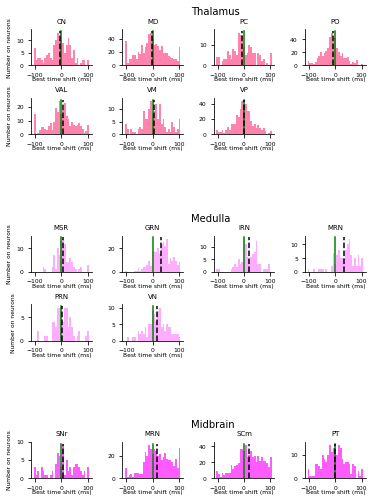

In [23]:
plt.rcParams['figure.figsize'][1] = style.fig_w_max * 7 / 6
plt.subplots(7,4)
plt.subplots_adjust(hspace = 0.9, wspace = 0.5)
#plt.subplots_adjust(top = 0.95)

filter_extreme_from_mean = True
plot_zero_line = True

extreme_inds = np.where((np.abs(best_times) > 100))[0]

for i_thalamus in range(len(thalamus_inds.keys())):
    plt.subplot(7,4, i_thalamus + 1)
    area = list(thalamus_inds.keys())[i_thalamus]
    _this_inds = thalamus_inds[area]
    plt.title(short_name_dict[area])
    
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = region2color['Thalamus'], alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f'%(area, mean, p_value))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'g-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.legend()
    if i_thalamus%4 == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best time shift (ms)', labelpad = -0.4)
    if i_thalamus == 1:
        plt.text(plt.xlim()[1] + 30, plt.ylim()[1]*1.4, 'Thalamus')

for ii in range(len(thalamus_inds.keys()),8):
    plt.subplot(7,4,ii + 1)
    plt.axis('off')

for i_medulla in range(len(medulla_inds.keys())):
    plt.subplot(7,4, 12 +  i_medulla + 1)
    area = list(medulla_inds.keys())[i_medulla]
    _this_inds = medulla_inds[area]
    plt.title(short_name_dict[area])
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = region2color['Medulla'], alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f'%(area, mean, p_value))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'g-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.ylabel('Number on neurons')
    if i_medulla%4 == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best time shift (ms)', labelpad = -0.4)
    if i_medulla == 1:
        plt.text(plt.xlim()[1] + 30, plt.ylim()[1]*1.4, 'Medulla')

for ii in range(len(medulla_inds.keys()),8):
    plt.subplot(7,4, 12 + ii + 1)
    plt.axis('off')

for i_midbrain in range(len(midbrain_inds.keys())):
    plt.subplot(7,4, 24 + i_midbrain + 1)
    area = list(midbrain_inds.keys())[i_midbrain]
    _this_inds = midbrain_inds[area]
    plt.title(short_name_dict[area])
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = region2color['Midbrain'], alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f'%(area, mean, p_value))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], '-', color = 'green', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.ylabel('Number on neurons')
    if i_midbrain == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best time shift (ms)', labelpad = -0.4)
    if i_midbrain == 1:
        plt.text(plt.xlim()[1] + 30, plt.ylim()[1]*1.4, 'Midbrain')


for ii in range(4):
    plt.subplot(7,4, 8 + ii + 1)
    plt.axis('off')
    plt.subplot(7,4, 20 + ii + 1)
    plt.axis('off')

#plt.savefig(figfolder + 'timeshift_histgorams_v3.png', bbox_inches = 'tight', dpi = 300)


ALM - mean=7.49+/-1.50 ms, p=0.0000
Somatosensory areas - mean=-13.94+/-1.16 ms, p=0.0000
Somatomotor areas - mean=-8.59+/-3.00 ms, p=0.0183
Orbital area - mean=-20.65+/-2.30 ms, p=0.0000


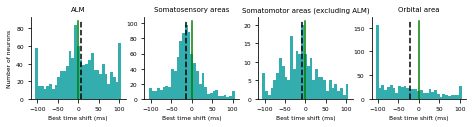

In [25]:
plt.subplots(1,4, figsize = (7.8,1.5))
n_comparisons = 4

for i_cortex in range(len(cortex_inds.keys())):
    plt.subplot(1,4, i_cortex + 1)
    area = list(cortex_inds.keys())[i_cortex]
    _this_inds = cortex_inds[area]
    if area == 'Somatomotor areas':
        plt.title(area + ' (excluding ALM)')
    else:
        plt.title(area)
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = region2color['ALM'], alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        sem = stats.sem(best_times[mean_inds])
        print('%s - mean=%.2f+/-%.2f ms, p=%.4f'%(area, mean,sem, p_value*n_comparisons))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'g-', label = 'zero')
    plt.xlabel('Best time shift (ms)')
    if i_cortex == 0:
        plt.ylabel('Number of neurons')

plt.savefig('../figs/supplementary_figs/cortex_timeshift_histograms.png', bbox_inches = 'tight', dpi = 300)

## Statistics

In [17]:
thalamus_grouped_times = [best_times[_this_inds] for _this_inds in thalamus_inds.values()]
medulla_grouped_times = [best_times[_this_inds] for _this_inds in medulla_inds.values()]
midbrain_grouped_times = [best_times[_this_inds] for _this_inds in midbrain_inds.values()]
cortex_grouped_times = [best_times[_this_inds] for _this_inds in cortex_inds.values()]

f_thalamus, p_thalamus = stats.f_oneway(*thalamus_grouped_times)
f_medulla, p_medulla = stats.f_oneway(*medulla_grouped_times)
f_midbrain, p_midbrain = stats.f_oneway(*midbrain_grouped_times)
f_cortex, p_cortex = stats.f_oneway(*cortex_grouped_times)

n_comps = 4

print('Thalamus: F=%.2f, p=%.5f'%(f_thalamus, p_thalamus*n_comps))
print('Medulla: F=%.2f, p=%.5f'%(f_medulla, p_medulla*n_comps))
print('Midbrain: F=%.2f, p=%.5f'%(f_midbrain, p_midbrain*n_comps))
print('Cortex: F=%.2f, p=%.5f'%(f_cortex, p_cortex*n_comps))

Thalamus: F=3.47, p=0.00817
Medulla: F=14.77, p=0.00000
Midbrain: F=12.16, p=0.00000
Cortex: F=90.83, p=0.00000


# Work on pairwise comparisons

In [65]:
f7.load_data()
fr_threshold = 2
r2_threshold = 0.01
delta_threshold = 1.2
thalamus_inds,_ = f7.get_thalamus_inds(n_threshold = 50, fr_threshold = fr_threshold, r2_threshold = r2_threshold, delta_r2 = delta_threshold)
cortex_inds,_ = f7.get_cortex_inds(n_threshold = 100,fr_threshold = fr_threshold, r2_threshold = r2_threshold, delta_r2 = delta_threshold)
medulla_inds,_ = f7.get_medulla_inds(n_threshold = 50,fr_threshold = fr_threshold, r2_threshold = r2_threshold, delta_r2 = delta_threshold)
midbrain_inds,_ = f7.get_midbrain_inds(n_threshold = 50,fr_threshold = fr_threshold, r2_threshold = r2_threshold, delta_r2 = delta_threshold)
best_times = f7.get_best_timeshift()

In [66]:
thalamus_inds[area1].shape, thalamus_inds[area2].shape

((516,), (134,))

In [10]:
def plot_timeshift_histogram(ax,area_best_times, area_name, color = 'blue', zero_line = True, print_label = True):
    ax.hist(area_best_times, bins = np.linspace(-105.4,105.4,32), color = color, alpha = 0.9)
    mean = area_best_times.mean()
    sem = stats.sem(area_best_times)
    a,b = ax.get_ylim()
    if zero_line: ax.plot([0,0], [0,1.1*b], ':', color = 'black',)
    ax.plot([mean, mean], [0,1.1*b], 'w--',  lw = 2 ,label = r'$\tau = %.1f \pm %.1f$ ms'%(mean,sem))
    if print_label:
        print('%s, tau = %.1f +/- %.1f ms'%(area_name,mean,sem))
    
    ax.set_ylim(0,1.1*b)
    ax.set_title('%s, n=%d'%(area_name,len(area_best_times)))
    ax.set_xlabel('Best time shift (ms)')
    ax.set_ylabel('Number of neurons')
    ax.legend()

Somatosensory areas, tau = -14.0 +/- 1.3 ms
Posterior complex of the thalamus, tau = -12.5 +/- 1.7 ms
Medulla, sensory related, tau = 8.6 +/- 3.2 ms
Pretectal region, tau = -1.6 +/- 3.2 ms
ALM, tau = 7.1 +/- 1.7 ms
Ventral medial nucleus of the thalamus, tau = 1.9 +/- 4.4 ms
Gigantocellular reticular nucleus, tau = 33.8 +/- 2.1 ms
Superior colliculus, motor related, tau = 19.8 +/- 1.9 ms


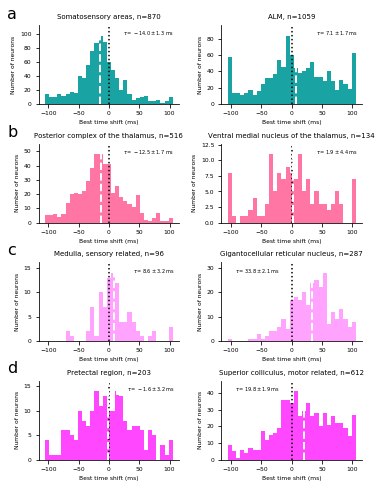

In [18]:
f,axs = plt.subplots(4,2, figsize = (5.8,8))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)

cortex_areas = ['Somatosensory areas',
                'ALM']

thalamus_areas = ['Posterior complex of the thalamus',
                  'Ventral medial nucleus of the thalamus']

medulla_areas = ['Medulla, sensory related',#'Medulla, sensory related',
                 'Gigantocellular reticular nucleus']#'Intermediate reticular nucleus']

midbrain_areas = ['Pretectal region',
                  'Superior colliculus, motor related']

for i in range(2):
    plot_timeshift_histogram(axs[0,i], best_times[cortex_inds[cortex_areas[i]]], cortex_areas[i], region2color['ALM'])
    plot_timeshift_histogram(axs[1,i], best_times[thalamus_inds[thalamus_areas[i]]], thalamus_areas[i], region2color['Thalamus'])
    plot_timeshift_histogram(axs[2,i], best_times[medulla_inds[medulla_areas[i]]], medulla_areas[i], region2color['Medulla'])
    plot_timeshift_histogram(axs[3,i], best_times[midbrain_inds[midbrain_areas[i]]], midbrain_areas[i], region2color['Midbrain'])


for i in range(4):
    f.text(0.05, 0.89 - 0.205 * i, chr(97+i), fontsize = 16)

plt.savefig(figfolder + 'timeshift_histograms_pairwise_v2.png', bbox_inches = 'tight', dpi = 300)

In [12]:
n_comps = 4

u,p = stats.mannwhitneyu(best_times[thalamus_inds[thalamus_areas[0]]], best_times[thalamus_inds[thalamus_areas[1]]])
print('Thalamus: %s vs %s, p=%.5f'%(thalamus_areas[0],thalamus_areas[1],p*n_comps))

u,p = stats.mannwhitneyu(best_times[medulla_inds[medulla_areas[0]]], best_times[medulla_inds[medulla_areas[1]]])
print('Medulla: %s vs %s, p=%.5f'%(medulla_areas[0],medulla_areas[1],p*n_comps))

u,p = stats.mannwhitneyu(best_times[midbrain_inds[midbrain_areas[0]]], best_times[midbrain_inds[midbrain_areas[1]]])
print('Midbrain: %s vs %s, p=%.5f'%(midbrain_areas[0],midbrain_areas[1],p*n_comps))

u,p = stats.mannwhitneyu(best_times[cortex_inds[cortex_areas[0]]], best_times[cortex_inds[cortex_areas[1]]])
print('Cortex: %s vs %s, p=%.5f'%(cortex_areas[0],cortex_areas[1],p*n_comps))


Thalamus: Posterior complex of the thalamus vs Ventral medial nucleus of the thalamus, p=0.00194
Medulla: Medulla, sensory related vs Gigantocellular reticular nucleus, p=0.00000
Midbrain: Pretectal region vs Superior colliculus, motor related, p=0.00000
Cortex: Somatosensory areas vs ALM, p=0.00000


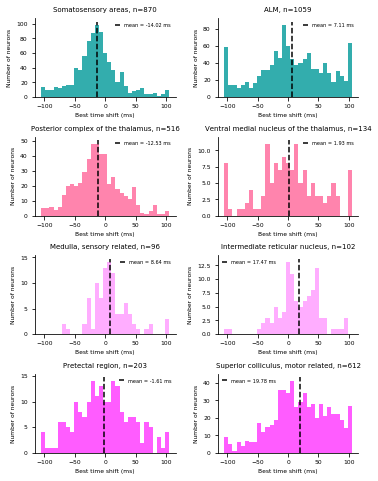

In [16]:
f,axs = plt.subplots(4,2, figsize = (5.8,8))
f.subplots_adjust(hspace = 0.5, wspace = 0.3)

cortex_areas = ['Somatosensory areas',
                'ALM']

thalamus_areas = ['Posterior complex of the thalamus',
                  'Ventral medial nucleus of the thalamus']

medulla_areas = ['Medulla, sensory related',#'Medulla, sensory related',
                 'Intermediate reticular nucleus']

midbrain_areas = ['Pretectal region',
                  'Superior colliculus, motor related']


for i in range(2):

    axs[0,i].hist(best_times[cortex_inds[cortex_areas[i]]], 
             bins = np.linspace(-105.4,105.4,32), 
             color = region2color['ALM'], 
             alpha = 0.8)
    axs[0,i].set_title('%s, n=%d'%(cortex_areas[i], cortex_inds[cortex_areas[i]].shape[0]))
    mean = np.mean(best_times[cortex_inds[cortex_areas[i]]])
    #median = np.median(best_times[cortex_inds[cortex_areas[i]]])
    ymax = axs[0,i].get_ylim()[1]
    axs[0,i].plot([mean, mean], [0,ymax], 'k--', label = 'mean = %.2f ms'%mean)
    #axs[0,i].plot([median, median], [0,ymax], 'k:', label = 'median = %.2f'%median)
    axs[0,i].legend()
    axs[0,i].set_ylabel('Number of neurons')
    axs[0,i].set_xlabel('Best time shift (ms)')

    axs[1,i].hist(best_times[thalamus_inds[thalamus_areas[i]]],
                bins = np.linspace(-105.4,105.4,32),
                color = region2color['Thalamus'],
                alpha = 0.8)
    axs[1,i].set_title('%s, n=%d'%(thalamus_areas[i], thalamus_inds[thalamus_areas[i]].shape[0]))
    mean = np.mean(best_times[thalamus_inds[thalamus_areas[i]]])
    median = np.median(best_times[thalamus_inds[thalamus_areas[i]]])
    ymax = axs[1,i].get_ylim()[1]
    axs[1,i].plot([mean, mean], [0,ymax], 'k--', label = 'mean = %.2f ms'%mean)
    #axs[1,i].plot([median, median], [0,ymax], 'k:', label = 'median = %.2f'%median)
    axs[1,i].legend()
    axs[1,i].set_xlabel('Best time shift (ms)')
    axs[1,i].set_ylabel('Number of neurons')

    axs[2,i].hist(best_times[medulla_inds[medulla_areas[i]]],
                bins = np.linspace(-105.4,105.4,32),
                color = region2color['Medulla'],
                alpha = 0.8)
    axs[2,i].set_title('%s, n=%d'%(medulla_areas[i], medulla_inds[medulla_areas[i]].shape[0]))
    mean = np.mean(best_times[medulla_inds[medulla_areas[i]]])
    median = np.median(best_times[medulla_inds[medulla_areas[i]]])
    ymax = axs[2,i].get_ylim()[1]
    axs[2,i].plot([mean, mean], [0,ymax], 'k--', label = 'mean = %.2f ms'%mean)
    #axs[2,i].plot([median, median], [0,ymax], 'k:', label = 'median = %.2f'%median)
    axs[2,i].legend()
    axs[2,i].set_xlabel('Best time shift (ms)')
    axs[2,i].set_ylabel('Number of neurons')

    axs[3,i].hist(best_times[midbrain_inds[midbrain_areas[i]]],
                bins = np.linspace(-105.4,105.4,32),
                color = region2color['Midbrain'],
                alpha = 0.8)
    axs[3,i].set_title('%s, n=%d'%(midbrain_areas[i], midbrain_inds[midbrain_areas[i]].shape[0]))
    mean = np.mean(best_times[midbrain_inds[midbrain_areas[i]]])
    median = np.median(best_times[midbrain_inds[midbrain_areas[i]]])
    ymax = axs[3,i].get_ylim()[1]
    axs[3,i].plot([mean, mean], [0,ymax], 'k--', label = 'mean = %.2f ms'%mean)
    #axs[3,i].plot([median, median], [0,ymax], 'k:', label = 'median = %.2f'%median)
    axs[3,i].legend()
    axs[3,i].set_xlabel('Best time shift (ms)')
    axs[3,i].set_ylabel('Number of neurons')

#plt.savefig(figfolder + 'timeshift_histograms_pairwise_v1.png', bbox_inches = 'tight', dpi = 300)

### ALM vs Somatosensory cortex comparison

ALM - mean=7.49 ms, p=0.0000
Somatosensory areas - mean=-13.94 ms, p=0.0000


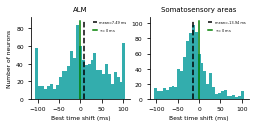

In [27]:
plt.subplots(1,2, figsize = (3.9,1.5))

for i_cortex in range(2):
    plt.subplot(1,2, i_cortex + 1)
    area = list(cortex_inds.keys())[i_cortex]
    _this_inds = cortex_inds[area]
    plt.title(area)
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = region2color['ALM'], alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f'%(area, mean, p_value))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean=%.2f ms'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'g-', label = r'$\tau = 0$ ms')
    plt.xlabel('Best time shift (ms)')
    if i_cortex == 0:
        plt.ylabel('Number of neurons')
    plt.legend(fontsize = 3.5)
plt.savefig('../figs/supplementary_figs/cortex_timeshift_histograms_alm_somatosensory.png', bbox_inches = 'tight', dpi = 300)

/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


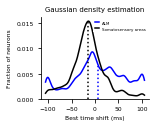

In [59]:
# I want ot calculate a gaussian KDE of eahc of the histograms
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

plt.subplots(1,1, figsize = (1.95,1.5))
xx = np.linspace(-105.4,105.4,1000)
plt.subplot(1,1,1)
plt.title('Gaussian density estimation')
cols = ['blue', 'k']
for i_cortex in range(2):
    
    area = list(cortex_inds.keys())[i_cortex]
    _this_inds = cortex_inds[area]
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
    plt.xlabel('Best time shift (ms)')
    if i_cortex == 0:
        plt.ylabel('Fraction of neurons')
    kde = KernelDensity(kernel='gaussian', bandwidth=6).fit(best_times[_this_inds].reshape(-1,1))
    log_dens = kde.score_samples(xx.reshape(-1,1), )
    
    plt.plot(xx, np.exp(log_dens), '-',color = cols[i_cortex],label = area)
    
    plt.plot([mean, mean], [0, np.exp(kde.score_samples([[mean]], ))], linestyle = 'dotted',color = cols[i_cortex],)
    
a,b = plt.ylim()
plt.ylim(0,b)
plt.legend(fontsize = 4.)
plt.savefig('../figs/supplementary_figs/cortex_timeshift_kde_alm_somatosensory.png', bbox_inches = 'tight', dpi = 300)

# Misc analyses

### Additional regions

In [10]:
fig7 = utils.Figure7()
fig7.load_data()


In [29]:
extra_areas = [
    'External cuneate nucleus',
    'Spinal nucleus of the trigeminal, caudal part',
    'Spinal nucleus of the trigeminal, interpolar part',
    'Superior colliculus, sensory related',
    'Inferior colliculus',
    #'Nucleus of the lateral lemniscus',
    'Pons, sensory related']

extra_area_shortname_dict = {
    "External cuneate nucleus": "ECU",
    "Spinal nucleus of the trigeminal, caudal part": "SPVC",
    "Spinal nucleus of the trigeminal, interpolar part": "SPVI",
    "Superior colliculus, sensory related": "SCs",
    "Inferior colliculus": "IC",
     "Nucleus of the lateral lemniscus": "NLL",
    "Pons, sensory related": "PonsSR"
}

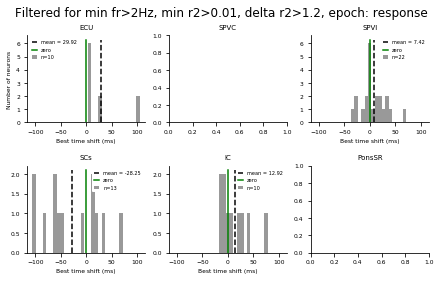

In [37]:
f,_ = plt.subplots(2,3, figsize = (7.2,4))
f.subplots_adjust(hspace = 0.5)
best_times = fig7.get_best_timeshift()
filter_extreme_from_mean = False
plot_zero_line = True

for i in range(6):
    plt.subplot(2,3,i+1)
    area = extra_areas[i]
    _this_inds = fig7.get_single_region_inds(area)
    plt.title(extra_area_shortname_dict[area])
    if _this_inds is None:
        continue
    
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'gray', alpha = 0.8, label = 'n=%d'%len(_this_inds))
    extreme_inds = np.where((np.abs(best_times) > 100))[0]
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f, n=%d'%(area, mean, p_value,len(_this_inds)))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'g-', label = 'zero')
    plt.legend()
    plt.xlabel('Best time shift (ms)')
    if i == 0:
        plt.ylabel('Number of neurons')

f.suptitle('Filtered for min fr>2Hz, min r2>0.01, delta r2>1.2, epoch: response', fontsize = 12)
plt.savefig('../figs/timeshift/extra_sensory_regions_filtered_neurons.png', bbox_inches = 'tight', dpi = 300)

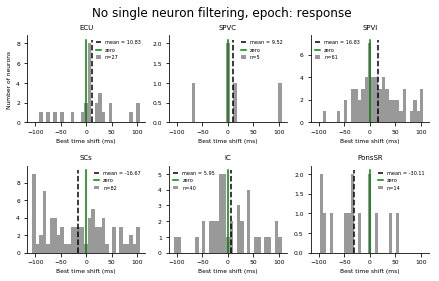

In [38]:
f,_ = plt.subplots(2,3, figsize = (7.2,4))
f.subplots_adjust(hspace = 0.5)
best_times = fig7.get_best_timeshift()
filter_extreme_from_mean = False
plot_zero_line = True

for i in range(6):
    plt.subplot(2,3,i+1)
    area = extra_areas[i]
    _this_inds = fig7.get_single_region_inds(area, r2_threshold=0, fr_threshold=0, delta_r2=1.)
    plt.title(extra_area_shortname_dict[area])
    if _this_inds is None:
        continue
    plt.hist(best_times[_this_inds], bins = np.linspace(-105.4,105.4,32), color = 'gray', alpha = 0.8, label = 'n=%d'%len(_this_inds))
    
    extreme_inds = np.where((np.abs(best_times) > 100))[0]
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f, n=%d'%(area, mean, p_value,len(_this_inds)))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'g-', label = 'zero')
    plt.legend()
    plt.xlabel('Best time shift (ms)')
    if i == 0:
        plt.ylabel('Number of neurons')

f.suptitle('No single neuron filtering, epoch: response', fontsize = 12)
plt.savefig('../figs/timeshift/extra_sensory_regions_no_filter.png', bbox_inches = 'tight', dpi = 300)

### Edge timeshift neurons

183

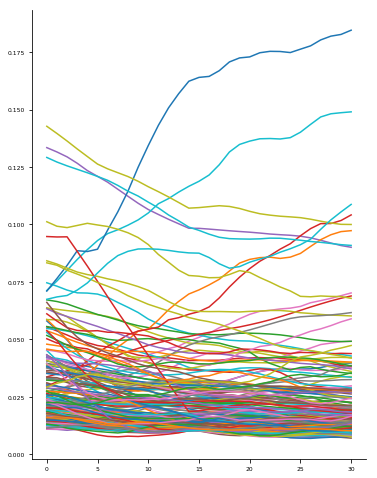

In [25]:
extreme_inds = np.where(np.abs(best_times) > 100)[0]

example_neuron_inds = np.intersect1d(extreme_inds, cortex_inds['Orbital area'])

plt.plot(r2[:,example_neuron_inds]);
len(example_neuron_inds)

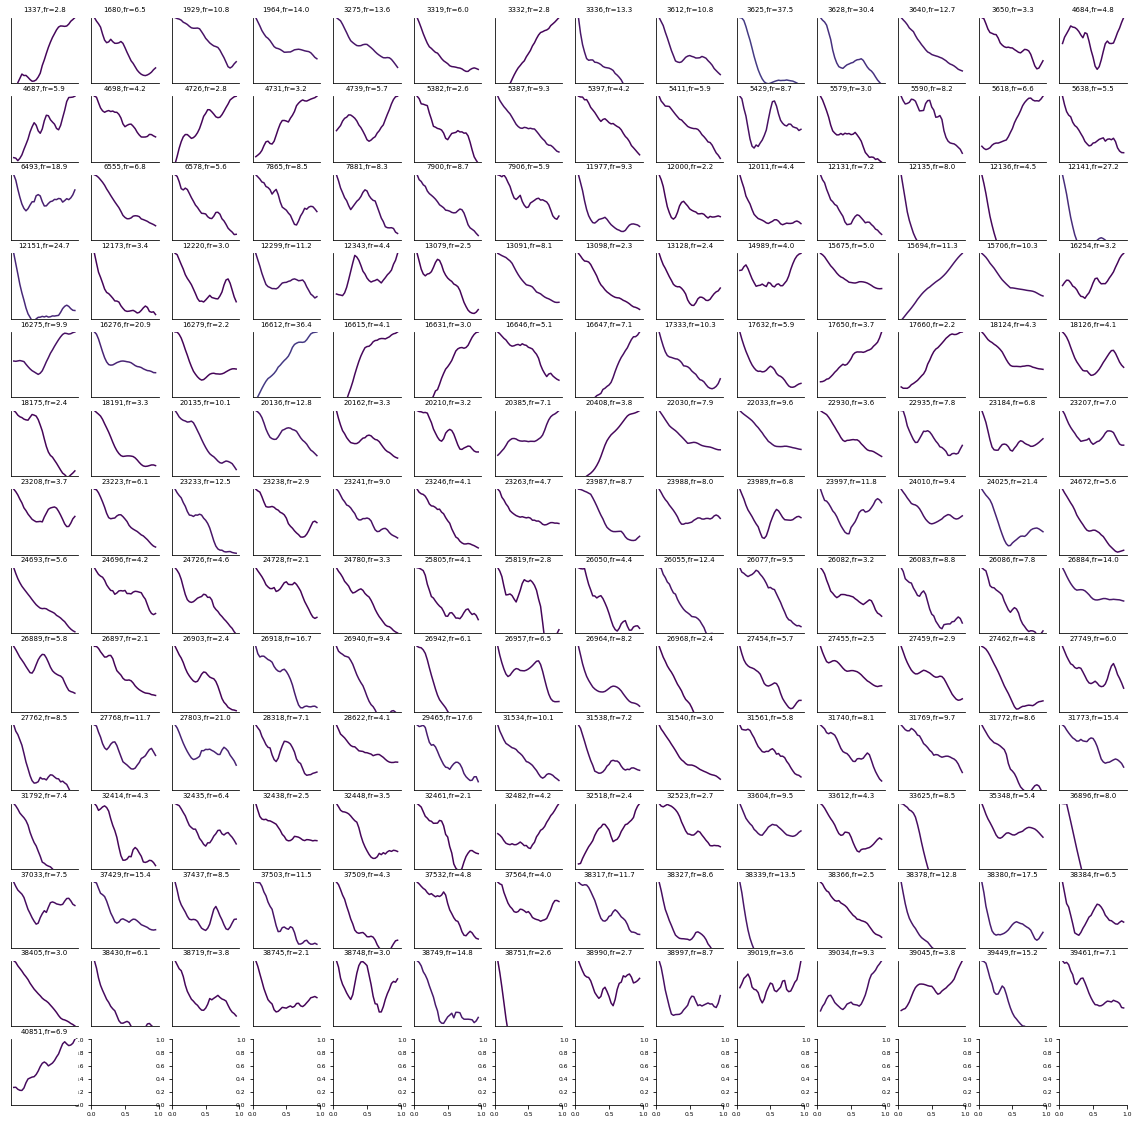

In [26]:
plt.subplots(14,14, figsize = (20,20))
for i in range(len(example_neuron_inds)):
    plt.subplot(14,14,i+1)
    _fr = fr[example_neuron_inds[i]]
    plt.plot(3.4*timeshifts,r2[:,example_neuron_inds[i]]/r2[:,example_neuron_inds[i]].max(), color = plt.cm.viridis(_fr/np.max(fr)))
    plt.title('%d,fr=%.1f'%(example_neuron_inds[i],_fr))
    plt.ylim(0.5,1)
    plt.xticks([])
    plt.yticks([]) 

In [27]:
extreme_orbital_neurons = {}

for i in example_neuron_inds:
    extreme_orbital_neurons[i] = {
        'session': r2_new['5_0']['session_name'][i], 
        'ccf_label': r2_new['5_0']['ccf_labels'][i], 
        'ccf_coords': r2_new['5_0']['ccf_coords'][i],
        'within_session_ind': i - np.min(np.where(r2_new['5_0']['session_name'] == r2_new['5_0']['session_name'][i])[0])}

#pickle.dump(extreme_orbital_neurons, open(datafolder + 'extreme_orbital_neuron_inds.pkl', 'wb'))

In [42]:
orbital_neuron_data = pickle.load(open(datafolder + 'orbital_neuron_fr.pkl', 'rb'))
tt = orbital_neuron_data[1337]['tt']
descending_fr_inds = example_neuron_inds[np.argsort(fr[example_neuron_inds])[::-1]]
os.makedirs('../figs/extreme_timeshift_neurons/', exist_ok = True)
len(tt)

662

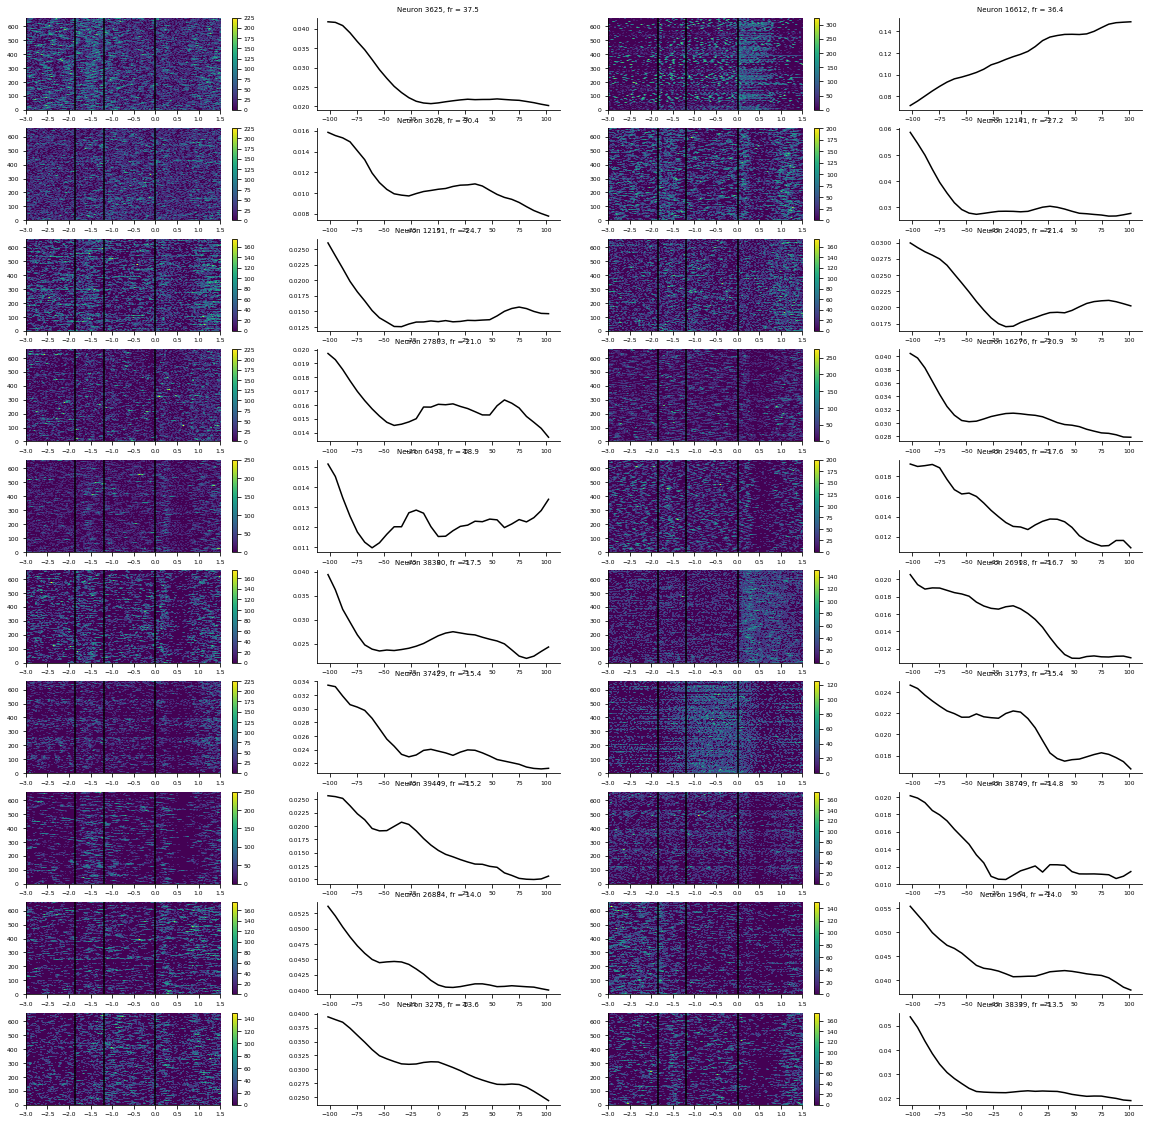

In [29]:
plt.subplots(10,4, figsize = (20,20))

for i in range(20):
    ind = descending_fr_inds[i]
    plt.subplot(10,4,2*i+1)
    plt.imshow(orbital_neuron_data[ind]['fr'].T, cmap = 'viridis', aspect = 'auto',
                extent = [tt[0], tt[-1], 0, orbital_neuron_data[ind]['fr'].shape[0]])
    plt.colorbar()
    plt.vlines([-1.85,-1.2,0], 0, orbital_neuron_data[ind]['fr'].shape[0], 'k')


    plt.subplot(10,4,2*i+2)
    plt.plot(3.4*timeshifts, r2[:,ind], 'k')
    plt.title('Neuron %d, fr = %.1f'%(ind, fr[ind]))

plt.savefig('../figs/extreme_timeshift_neurons/20_highest_fr_orbital_neurons.png', bbox_inches = 'tight', dpi = 300)

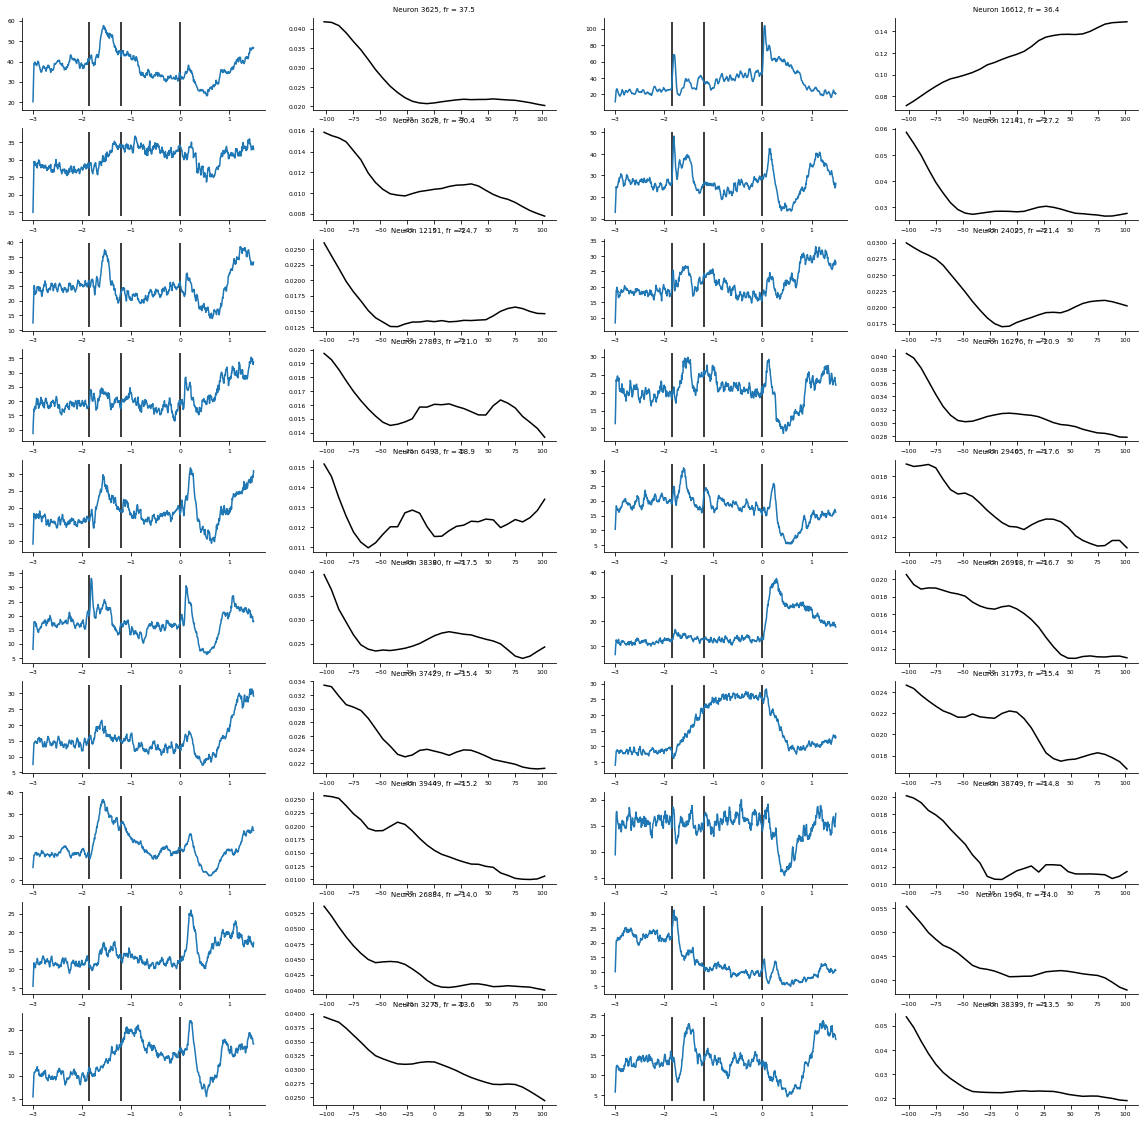

In [30]:
plt.subplots(10,4, figsize = (20,20))

for i in range(20):
    ind = descending_fr_inds[i]
    plt.subplot(10,4,2*i+1)
    plt.plot(tt, orbital_neuron_data[ind]['fr'].mean(axis = 1),)
    
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')


    plt.subplot(10,4,2*i+2)
    plt.plot(3.4*timeshifts, r2[:,ind], 'k')
    plt.title('Neuron %d, fr = %.1f'%(ind, fr[ind]))

plt.savefig('../figs/extreme_timeshift_neurons/20_highest_fr_orbital_neurons_mean_fr.png', bbox_inches = 'tight', dpi = 300)

In [31]:
r2_long_raw = pickle.load(open('../data/r2_embed_cv_timeshift_long.pkl', 'rb'))
timeshifts_long = np.arange(-60,62,2, dtype = int)
method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}
datafolder = '../data/'
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)
epoch = 'response'
r2_method = 'new'

r2_long = []
fr_long = r2_long_raw['5_0']['avg_fr'].copy()
ccf_coords_long = r2_long_raw['5_0']['ccf_coords'].copy()
ccf_labels_long = r2_long_raw['5_0']['ccf_labels'].copy()
alm_inds_long = np.where(r2_long_raw['5_0']['is_alm'] == True)[0]

for timesh in timeshifts_long:
    r2_long.append(r2_long_raw['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2_long = np.array(r2_long)
best_times_long = 3.4 * timeshifts_long[r2_long.argmax(axis = 0)]

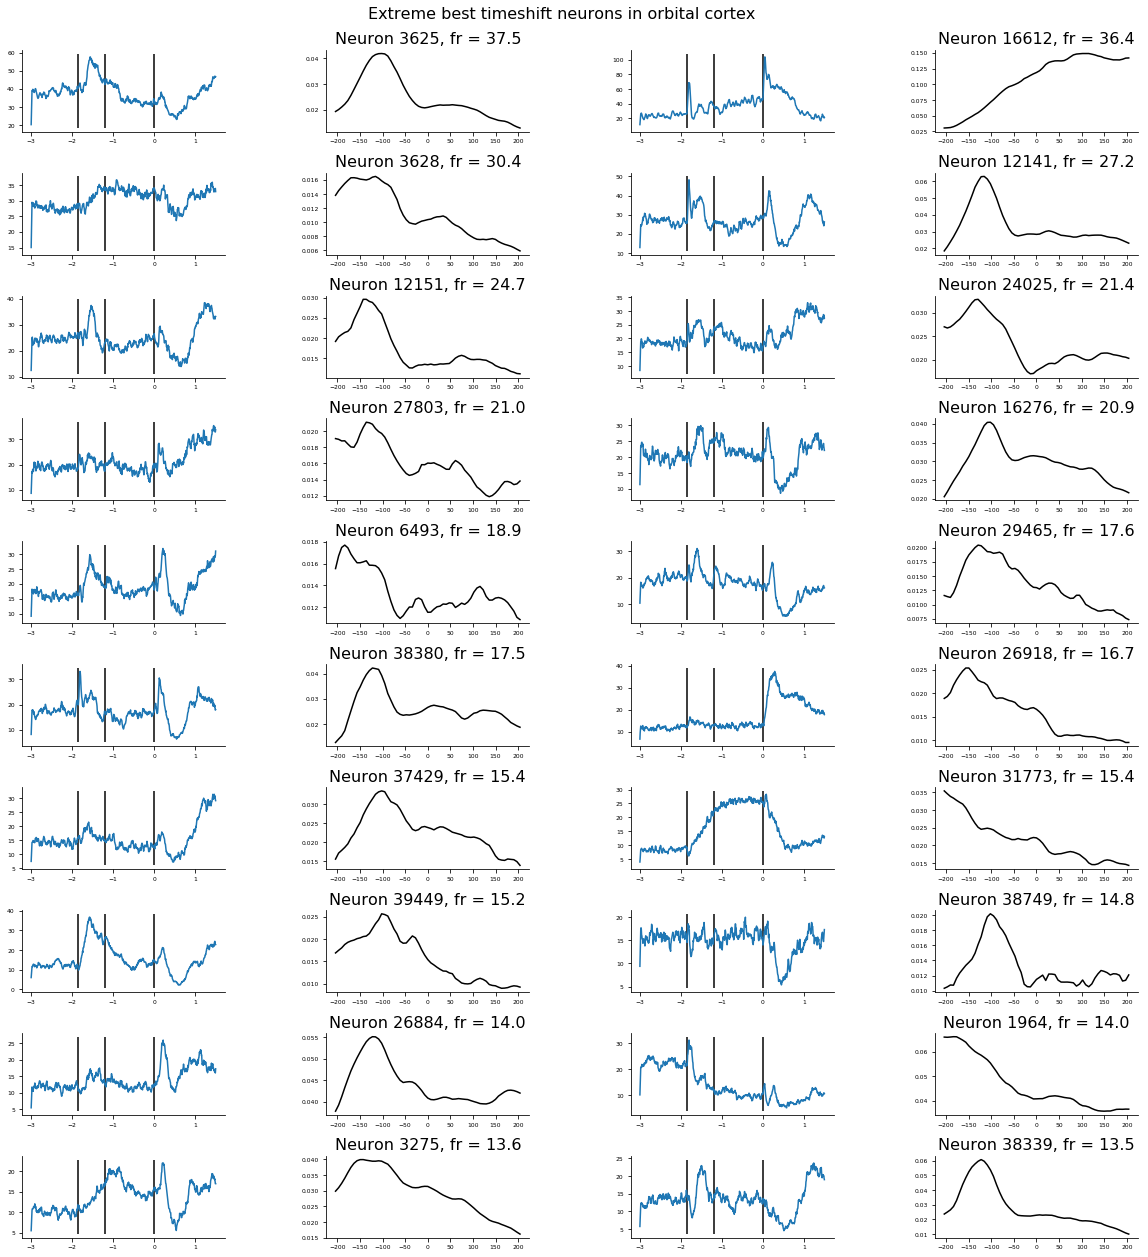

In [32]:
sess_array = np.array(r2_new['5_0']['session_name'])
sess_array_long = np.array(r2_long_raw['5_0']['session_name'])

f,_= plt.subplots(10,4, figsize = (20,20))
f.subplots_adjust(hspace = 0.5, wspace = 0.5, top = 0.95)
f.suptitle('Extreme best timeshift neurons in orbital cortex', fontsize = 16)

for i in range(20):
    ind = descending_fr_inds[i]
    plt.subplot(10,4,2*i+1)
    plt.plot(tt, orbital_neuron_data[ind]['fr'].mean(axis = 1),)
    
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')


    plt.subplot(10,4,2*i+2)
    withinsess_ind = ind - np.min(np.where(r2_new['5_0']['session_name'] == r2_new['5_0']['session_name'][ind])[0])
    sess = r2_new['5_0']['session_name'][ind]
    long_ind = np.where(sess_array_long == sess)[0][withinsess_ind]

    plt.plot(3.4*timeshifts_long, r2_long[:,long_ind], 'k')
    plt.title('Neuron %d, fr = %.1f'%(ind, fr[ind]), fontsize = 16)

plt.savefig('../figs/extreme_timeshift_neurons/20_highest_fr_orbital_neurons_mean_fr_longr2.png', bbox_inches = 'tight', dpi = 300)

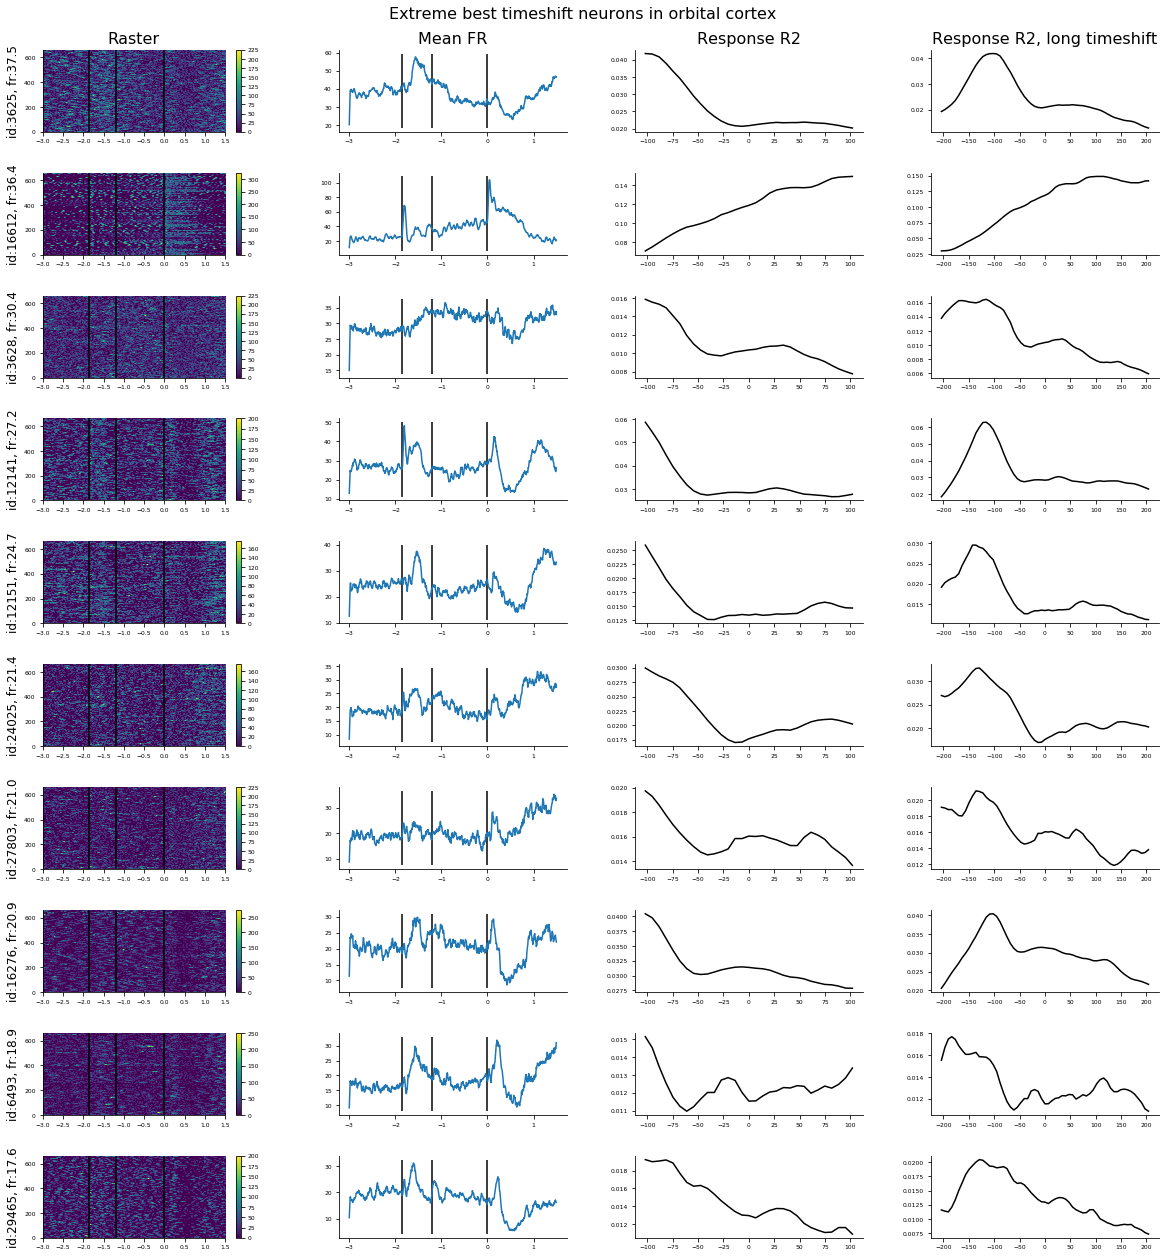

In [33]:
sess_array = np.array(r2_new['5_0']['session_name'])
sess_array_long = np.array(r2_long_raw['5_0']['session_name'])

f,_= plt.subplots(10,4, figsize = (20,20))
f.subplots_adjust(hspace = 0.5, wspace = 0.3, top = 0.95)
f.suptitle('Extreme best timeshift neurons in orbital cortex', fontsize = 16)

for i in range(10):
    ind = descending_fr_inds[i]

    plt.subplot(10,4,4*i+1)
    if i == 0: plt.title('Raster', fontsize = 16)
    plt.imshow(orbital_neuron_data[ind]['fr'].T, cmap = 'viridis', aspect = 'auto',
                extent = [tt[0], tt[-1], 0, orbital_neuron_data[ind]['fr'].shape[0]])
    plt.colorbar()
    plt.vlines([-1.85,-1.2,0], 0, orbital_neuron_data[ind]['fr'].shape[0], 'k')
    plt.ylabel('id:%d, fr:%.1f'%(ind, fr[ind]), fontsize = 12)

    plt.subplot(10,4,4*i+2)
    if i == 0: plt.title('Mean FR', fontsize = 16)
    plt.plot(tt, orbital_neuron_data[ind]['fr'].mean(axis = 1),)
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')

    plt.subplot(10,4,4*i+3)
    if i == 0: plt.title('Response R2', fontsize = 16)
    plt.plot(3.4*timeshifts, r2[:,ind], 'k')

    plt.subplot(10,4,4*i+4)
    if i == 0: plt.title('Response R2, long timeshift', fontsize = 16)
    withinsess_ind = ind - np.min(np.where(r2_new['5_0']['session_name'] == r2_new['5_0']['session_name'][ind])[0])
    sess = r2_new['5_0']['session_name'][ind]
    long_ind = np.where(sess_array_long == sess)[0][withinsess_ind]

    plt.plot(3.4*timeshifts_long, r2_long[:,long_ind], 'k')

plt.savefig('../figs/extreme_timeshift_neurons/10_highest_fr_orbital_neurons_allstats.png', bbox_inches = 'tight', dpi = 300)

In [43]:
orbital_neuron_data = pickle.load(open(datafolder + 'orbital_neuron_fr_spiketimes.pkl', 'rb'))
tt = orbital_neuron_data[1337]['tt']
descending_fr_inds = example_neuron_inds[np.argsort(fr[example_neuron_inds])[::-1]]

The different number of trilas in 'fr' and in 'spike_times' is because spike times contains all trials, while fr only the ones that we used as train/test, thus the "regular" trials.

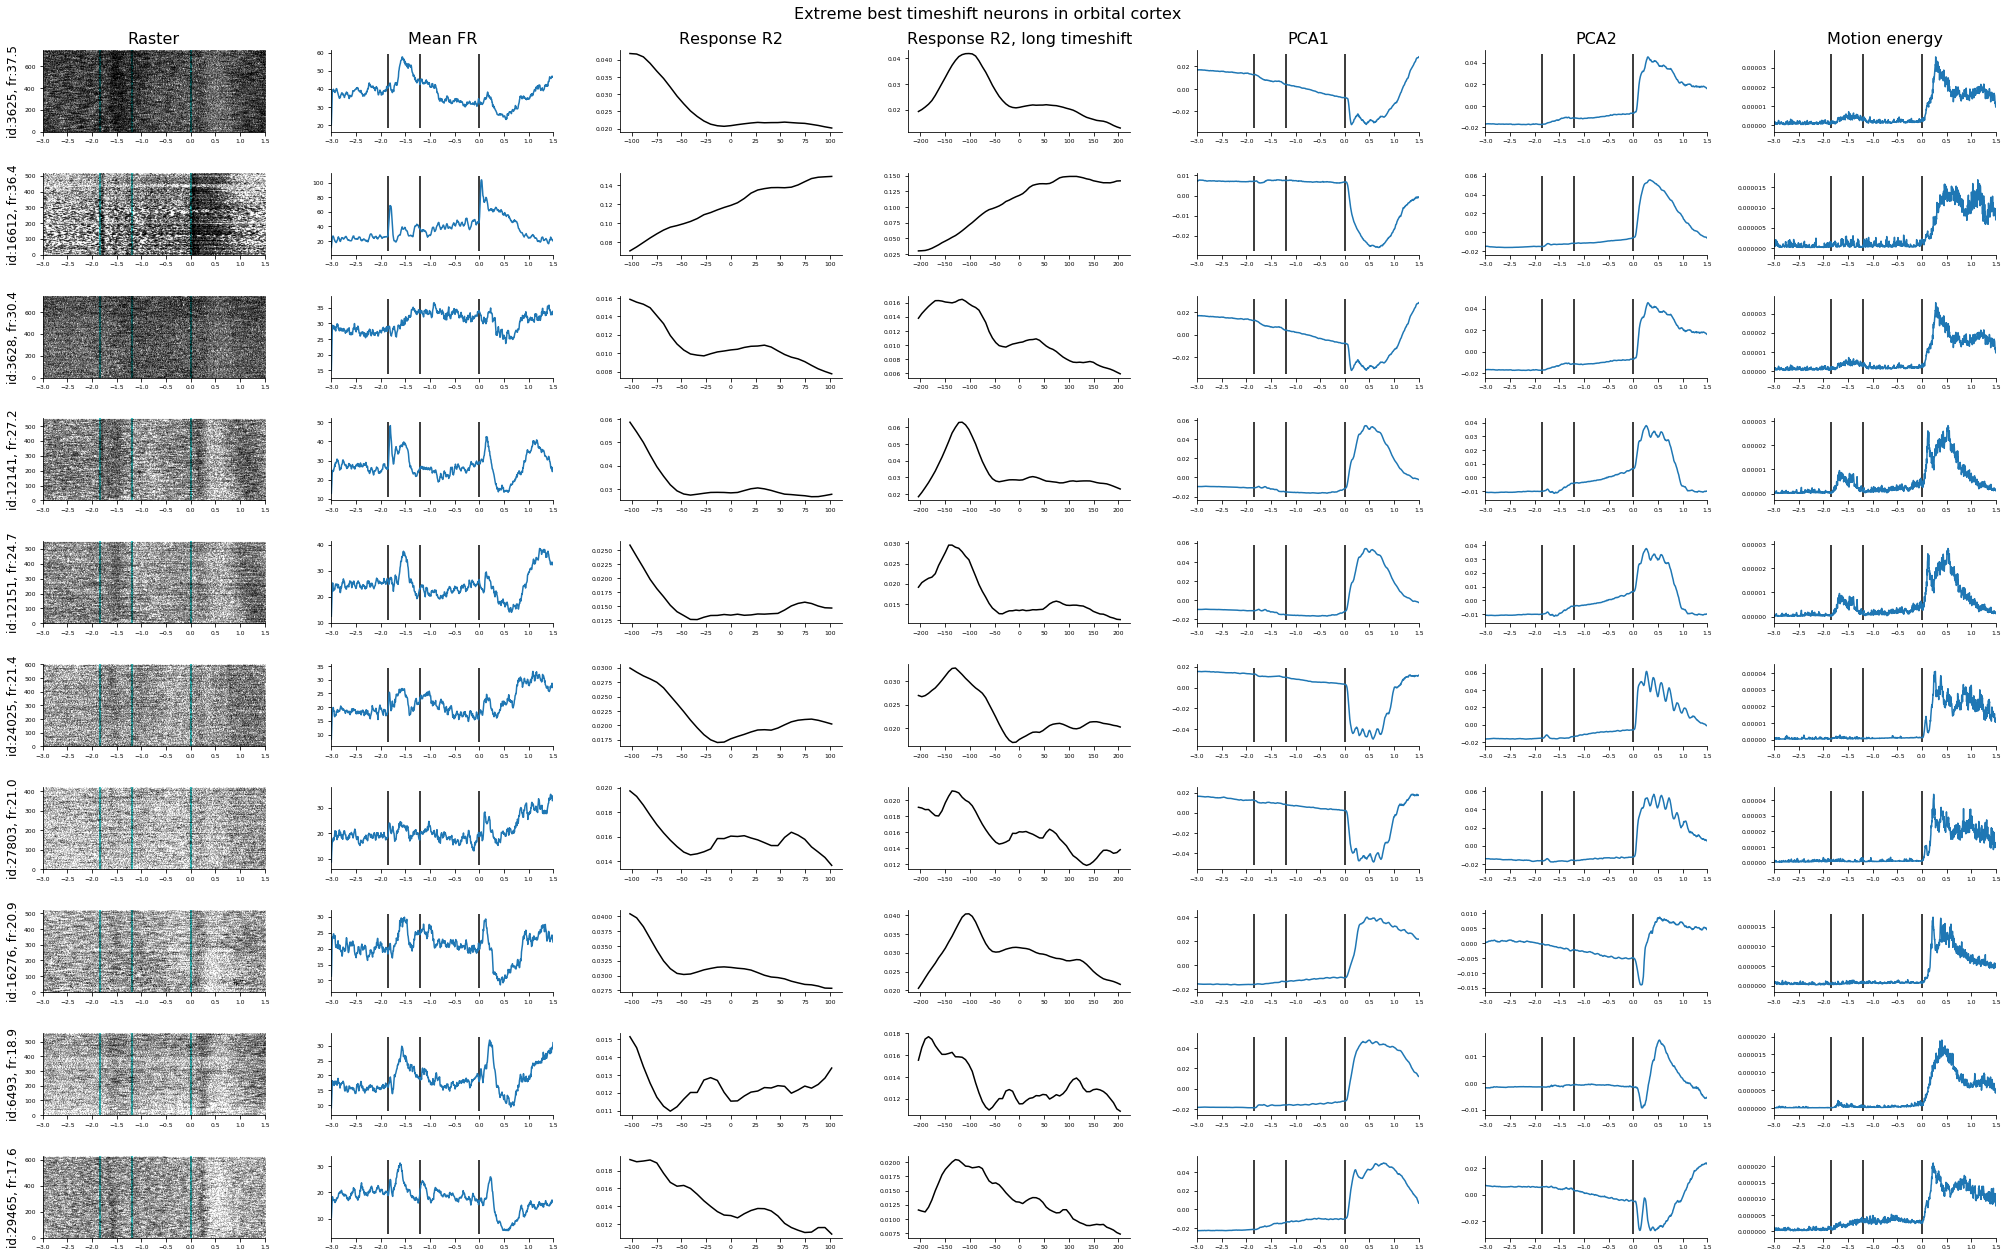

In [67]:
from sklearn.decomposition import PCA

embed_folder = '/media/kurgyis/TOSHIBA EXT/balint/Data/Map_aligned_embed_vecs/'
sess_array = np.array(r2_new['5_0']['session_name'])
sess_array_long = np.array(r2_long_raw['5_0']['session_name'])
pca = PCA(n_components = 2)

f,_= plt.subplots(10,7, figsize = (35,20))
f.subplots_adjust(hspace = 0.5, wspace = 0.3, top = 0.95)
f.suptitle('Extreme best timeshift neurons in orbital cortex', fontsize = 16)

for i in range(10):
    ind = descending_fr_inds[i]

    plt.subplot(10,7,7*i+1)
    if i == 0: plt.title('Raster', fontsize = 16)
    spike_times = orbital_neuron_data[ind]['spike_times']
    n_trials = spike_times.shape[0]
    for ii in range(n_trials):
        spikes = spike_times[ii]
        nspikes = len(spikes)
        plt.plot(spikes, np.ones(nspikes)*ii, 'k.', markersize = 0.1)
    plt.vlines([-1.85,-1.2,0], 0, n_trials, 'c')
    plt.ylabel('id:%d, fr:%.1f'%(ind, fr[ind]), fontsize = 12)
    plt.ylim(0,n_trials)
    plt.xlim(-3,1.5)

    plt.subplot(10,7,7*i+2)
    if i == 0: plt.title('Mean FR', fontsize = 16)
    plt.plot(tt, orbital_neuron_data[ind]['fr'].mean(axis = 1),)
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')
    plt.xlim(-3,1.5)

    plt.subplot(10,7,7*i+3)
    if i == 0: plt.title('Response R2', fontsize = 16)
    plt.plot(3.4*timeshifts, r2[:,ind], 'k')

    plt.subplot(10,7,7*i+4)
    if i == 0: plt.title('Response R2, long timeshift', fontsize = 16)
    withinsess_ind = ind - np.min(np.where(r2_new['5_0']['session_name'] == r2_new['5_0']['session_name'][ind])[0])
    sess = r2_new['5_0']['session_name'][ind]
    long_ind = np.where(sess_array_long == sess)[0][withinsess_ind]

    plt.plot(3.4*timeshifts_long, r2_long[:,long_ind], 'k')

    embed_file = pickle.load(open(embed_folder + orbital_neuron_data[ind]['session'] + '_aligned_embed.pkl', 'rb'))
    pca.fit(embed_file['embed'][:,:,:].reshape(-1,16))
    pcs = pca.transform(embed_file['embed'][:,:,:].reshape(-1,16)).reshape(embed_file['embed'].shape[0], embed_file['embed'].shape[1], 2)


    plt.subplot(10,7,7*i+5)
    if i == 0: plt.title('PCA1', fontsize = 16)
    plt.plot(embed_file['embed_time'], pcs[:,:,0].mean(axis = 1))
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')
    plt.xlim(-3,1.5)

    plt.subplot(10,7,7*i+6)
    if i == 0: plt.title('PCA2', fontsize = 16)
    plt.plot(embed_file['embed_time'], pcs[:,:,1].mean(axis = 1))
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')
    plt.xlim(-3,1.5)


    plt.subplot(10,7,7*i+7)
    if i == 0: plt.title('Motion energy', fontsize = 16)
    plt.plot(embed_file['embed_time'][1:], (np.diff(embed_file['embed'][:,:,:], axis = 0)**2).mean(axis =(1,2)))
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')
    plt.xlim(-3,1.5)
    

plt.savefig('../figs/extreme_timeshift_neurons/10_highest_fr_orbital_neurons_with_motion.png', bbox_inches = 'tight', dpi = 300)

### Periodic R2 neurons

Text(0.5,1,'Periodic neurons, n=239')

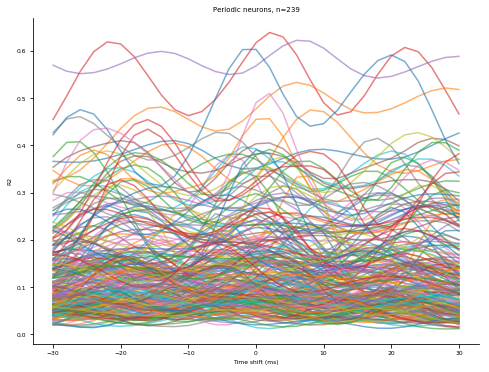

In [34]:
result = np.fft.fft(r2[:,]-np.mean(r2[:,], axis = 0), axis = 0)
periodic_neuron_inds = (np.intersect1d(np.where(np.argmax(np.abs(result)[:result.shape[0]//2,:], axis = 0)>2)[0], np.where(np.max(np.abs(result)[:result.shape[0]//2,:], axis = 0)>0.15)[0]))
#periodic_neuron_inds = (np.intersect1d(np.where(np.argmax(np.abs(result)[:result.shape[0]//2,:], axis = 0)>3)[0], np.where(np.max(np.abs(result)[:result.shape[0]//2,:], axis = 0)>0.25)[0]))

plt.figure(figsize = (8,6))
plt.plot(timeshifts,r2[:,periodic_neuron_inds], alpha = .6);
plt.xlabel('Time shift (ms)')
plt.ylabel('R2')
plt.title('Periodic neurons, n=%d'%len(periodic_neuron_inds))
#plt.savefig(figfolder + 'periodic_neurons.png', bbox_inches = 'tight', dpi = 300)

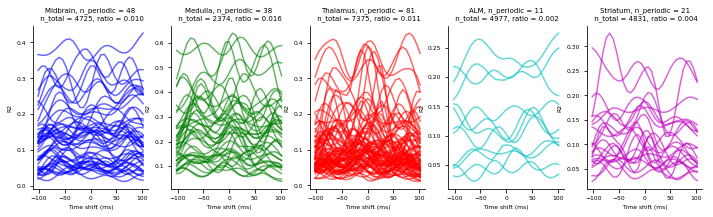

In [35]:
areas = ['Midbrain', 'Medulla', 'Thalamus', 'ALM', 'Striatum']
area_inds = func.get_inds_for_list_of_regions(areas, df, ccf_labels, alm_inds)

periodic_area_inds = {k: np.intersect1d(v, periodic_neuron_inds) for k,v in area_inds.items()}

plt.subplots(1,5, figsize = (12,3))
colors = ['b','g','r','c','m']
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    plt.title(area + ', n_periodic = %d\n n_total = %d, ratio = %.3f'%(len(periodic_area_inds[area]), len(area_inds[area]), len(periodic_area_inds[area])/len(area_inds[area])))
    plt.plot(3.4*timeshifts,r2[:,periodic_area_inds[area]], alpha = .6,color = colors[i], label = area);
    plt.ylabel('R2')
    plt.xlabel('Time shift (ms)')   
#plt.savefig(figfolder + 'periodic_neurons_large_areas.png', bbox_inches = 'tight', dpi = 300)

In [36]:
sample_r2 = []
for timesh in timeshifts:
    sample_r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%('sample',method_to_string[r2_method])].copy())

sample_r2 = np.array(sample_r2)
sample_best_times = 3.4 * timeshifts[sample_r2.argmax(axis = 0)]

delay_r2 = []
for timesh in timeshifts:
    delay_r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%('delay',method_to_string[r2_method])].copy())
delay_r2 = np.array(delay_r2)
delay_best_times = 3.4 * timeshifts[delay_r2.argmax(axis = 0)]

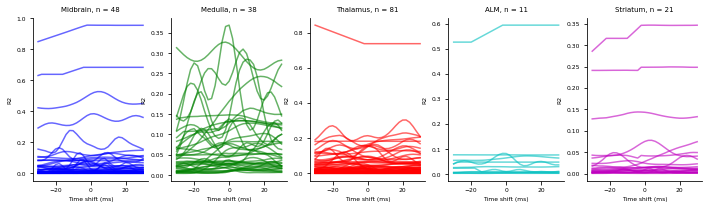

In [37]:
plt.subplots(1,5, figsize = (12,3))
colors = ['b','g','r','c','m']
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    plt.title(area + ', n = %d'%len(periodic_area_inds[area]))
    plt.plot(timeshifts,delay_r2[:,periodic_area_inds[area]], alpha = .6,color = colors[i], label = area);
    plt.ylabel('R2')
    plt.xlabel('Time shift (ms)')   
#plt.savefig(figfolder + 'periodic_neurons_large_areas.png', bbox_inches = 'tight', dpi = 300)

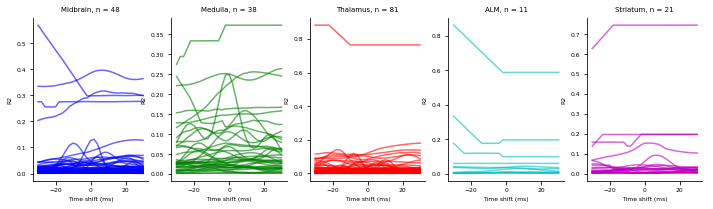

In [38]:
plt.subplots(1,5, figsize = (12,3))
colors = ['b','g','r','c','m']
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    plt.title(area + ', n = %d'%len(periodic_area_inds[area]))
    plt.plot(timeshifts,sample_r2[:,periodic_area_inds[area]], alpha = .6,color = colors[i], label = area);
    plt.ylabel('R2')
    plt.xlabel('Time shift (ms)')

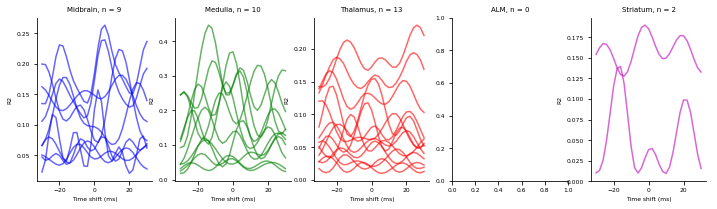

In [39]:
delay_fft = np.fft.fft(delay_r2[:,]-np.mean(delay_r2[:,], axis = 0), axis = 0)
delay_periodic_neuron_inds = (np.intersect1d(np.where(np.argmax(np.abs(delay_fft)[:delay_fft.shape[0]//2,:], axis = 0)>2)[0], np.where(np.max(np.abs(delay_fft)[:delay_fft.shape[0]//2,:], axis = 0)>0.14)[0]))
delay_periodic_area_inds = {k: np.intersect1d(v, delay_periodic_neuron_inds) for k,v in area_inds.items()}

plt.subplots(1,5, figsize = (12,3))
colors = ['b','g','r','c','m']
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    plt.title(area + ', n = %d'%len(delay_periodic_area_inds[area]))
    if len(delay_periodic_area_inds[area]) == 0:
        continue
    plt.plot(timeshifts,delay_r2[:,delay_periodic_area_inds[area]], alpha = .6,color = colors[i], label = area);
    plt.ylabel('R2')
    plt.xlabel('Time shift (ms)')   
#plt.savefig(figfolder + 'periodic_neurons_large_areas.png', bbox_inches = 'tight', dpi = 300)


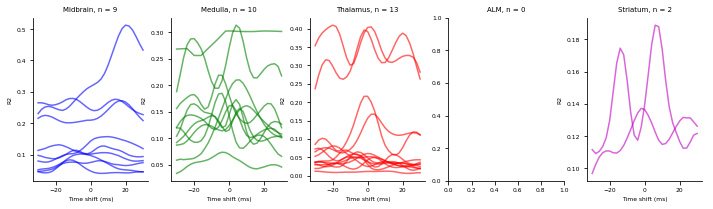

In [40]:
plt.subplots(1,5, figsize = (12,3))
colors = ['b','g','r','c','m']
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    plt.title(area + ', n = %d'%len(delay_periodic_area_inds[area]))
    if len(delay_periodic_area_inds[area]) == 0:
        continue
    plt.plot(timeshifts,r2[:,delay_periodic_area_inds[area]], alpha = .6,color = colors[i], label = area);
    plt.ylabel('R2')
    plt.xlabel('Time shift (ms)')   
#plt.savefig(figfolder + 'periodic_neurons_large_areas.png', bbox_inches = 'tight', dpi = 300)

In [41]:
np.intersect1d(delay_periodic_neuron_inds, periodic_neuron_inds)

array([ 3908,  6400, 16068, 37175, 37284])

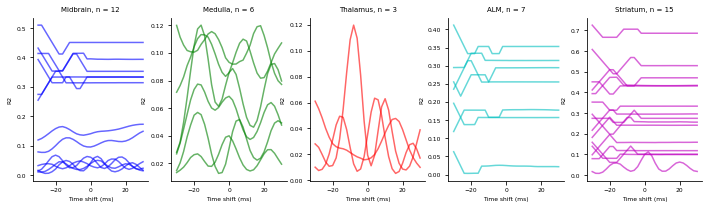

In [42]:
sample_fft = np.fft.fft(sample_r2[:,]-np.mean(sample_r2[:,], axis = 0), axis = 0)
sample_periodic_neuron_inds = (np.intersect1d(np.where(np.argmax(np.abs(sample_fft)[:sample_fft.shape[0]//2,:], axis = 0)>2)[0], np.where(np.max(np.abs(sample_fft)[:sample_fft.shape[0]//2,:], axis = 0)>0.1)[0]))
sample_periodic_area_inds = {k: np.intersect1d(v, sample_periodic_neuron_inds) for k,v in area_inds.items()}

plt.subplots(1,5, figsize = (12,3))
colors = ['b','g','r','c','m']
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    plt.title(area + ', n = %d'%len(sample_periodic_area_inds[area]))
    if len(sample_periodic_area_inds[area]) == 0:
        continue
    plt.plot(timeshifts,sample_r2[:,sample_periodic_area_inds[area]], alpha = .6,color = colors[i], label = area);
    plt.ylabel('R2')
    plt.xlabel('Time shift (ms)')   
#plt.savefig(figfolder + 'periodic_neurons_large_areas.png', bbox_inches = 'tight', dpi = 300)

In [43]:
np.intersect1d(sample_periodic_neuron_inds, periodic_neuron_inds)

array([ 3891, 13362, 13366, 18620, 37180])

In [44]:
np.unique(sess_array[periodic_neuron_inds])

array(['SC026_20190805_21', 'SC026_20190806_22', 'SC026_20190808_23',
       'SC027_20190729_17', 'SC027_20190803_21', 'SC027_20190804_22',
       'SC030_20191004_34', 'SC030_20191005_35', 'SC031_20191021_48',
       'SC032_20191218_55', 'SC032_20191219_56', 'SC033_20191113_32',
       'SC033_20191114_33', 'SC035_20200107_33', 'SC035_20200108_34',
       'SC035_20200109_35', 'SC035_20200110_36', 'SC038_20191119_5',
       'SC038_20191120_6', 'SC038_20191120_7', 'SC038_20191121_8',
       'SC038_20191122_10', 'SC038_20191122_11', 'SC038_20191123_13',
       'SC043_20200924_26', 'SC043_20200925_27', 'SC045_20201211_19',
       'SC045_20201214_21', 'SC045_20201217_22', 'SC048_20201230_14',
       'SC048_20201231_15', 'SC048_20210101_16', 'SC048_20210104_18',
       'SC049_20210107_15', 'SC049_20210108_16', 'SC050_20210226_17',
       'SC050_20210227_18', 'SC050_20210301_19', 'SC050_20210302_20',
       'SC050_20210303_21', 'SC052_20210121_3', 'SC053_20210221_8',
       'SC053_20210222_9',

In [45]:
periodic_neuron_dict = {}

for i in periodic_neuron_inds:
    periodic_neuron_dict[i] = {
        'session': r2_new['5_0']['session_name'][i], 
        'ccf_label': r2_new['5_0']['ccf_labels'][i], 
        'ccf_coords': r2_new['5_0']['ccf_coords'][i],
        'within_session_ind': i - np.min(np.where(r2_new['5_0']['session_name'] == r2_new['5_0']['session_name'][i])[0])}

pickle.dump(periodic_neuron_dict, open(datafolder + 'periodic_neuron_inds.pkl', 'wb'))

In [68]:
periodic_neuron_fr = pickle.load(open('../data/periodic_neuron_fr.pkl', 'rb'))
tt = periodic_neuron_fr[3891]['tt']
descending_fr_inds = periodic_neuron_inds[np.argsort(fr[periodic_neuron_inds])[::-1]]
os.makedirs('../figs/periodic_r2_neurons/', exist_ok = True)

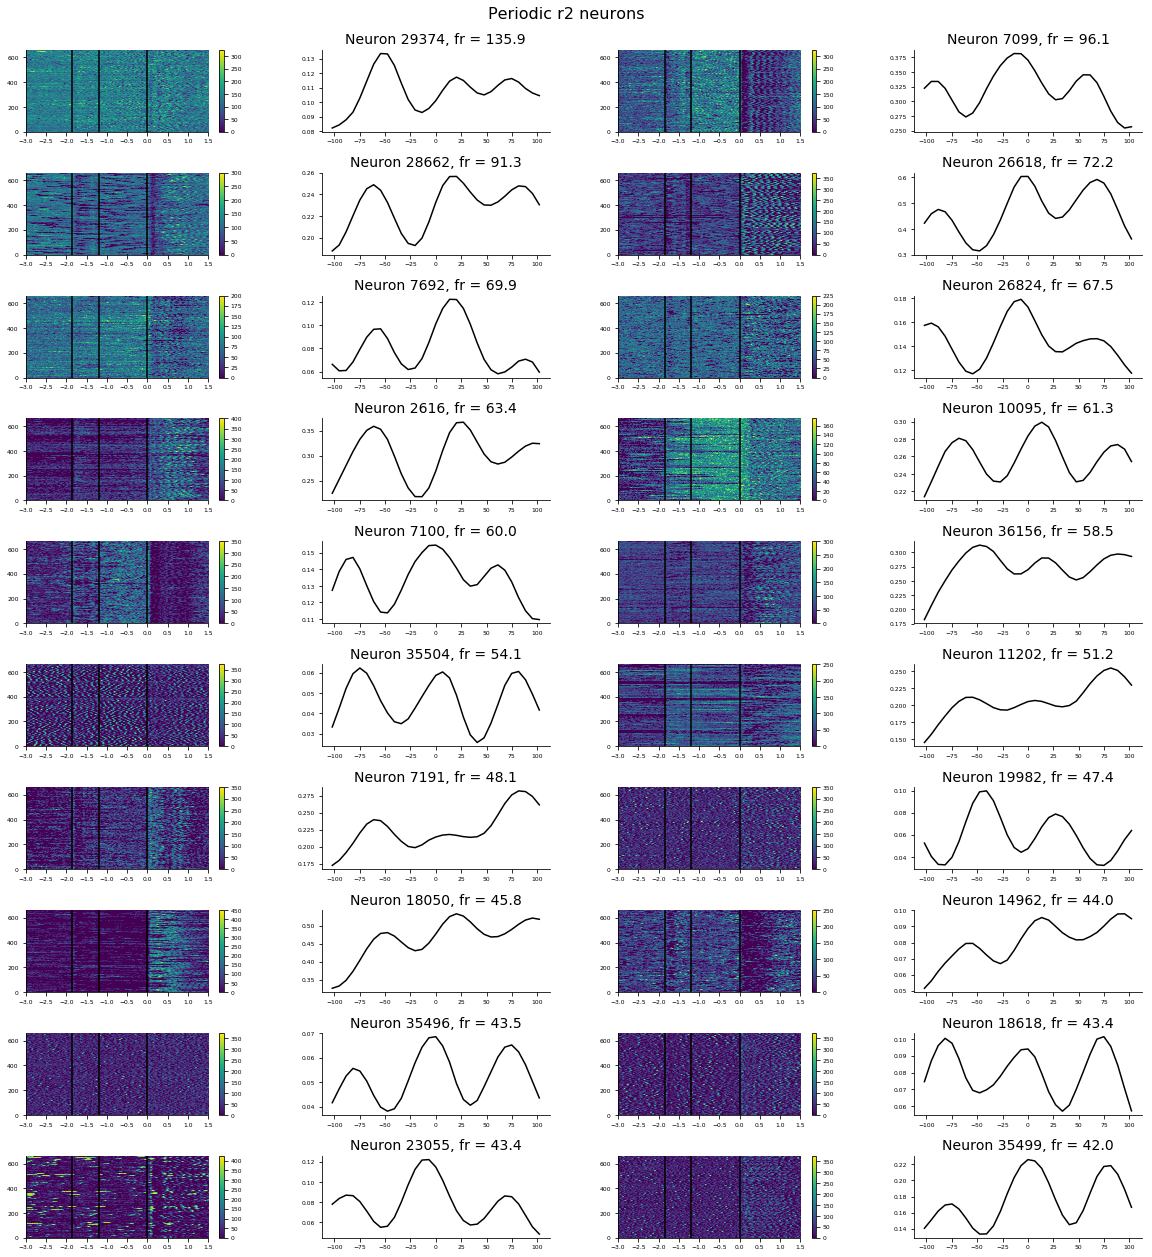

In [52]:
f,_ = plt.subplots(10,4, figsize = (20,20))
f.subplots_adjust(hspace = 0.5, wspace = 0.3, top = 0.95)
plt.suptitle('Periodic r2 neurons', fontsize = 16)

for i in range(20):
    ind = descending_fr_inds[i]
    plt.subplot(10,4,2*i+1)
    plt.imshow(periodic_neuron_fr[ind]['fr'].T, cmap = 'viridis', aspect = 'auto',
                extent = [tt[0], tt[-1], 0, periodic_neuron_fr[ind]['fr'].shape[0]])
    plt.colorbar()
    
    plt.vlines([-1.85,-1.2,0], 0, periodic_neuron_fr[ind]['fr'].shape[0], 'k')


    plt.subplot(10,4,2*i+2)
    plt.plot(3.4*timeshifts, r2[:,ind], 'k')
    plt.title('Neuron %d, fr = %.1f'%(ind, fr[ind]), fontsize = 14)

plt.savefig('../figs/periodic_r2_neurons/20_highest_fr_periodic_neurons.png', bbox_inches = 'tight', dpi = 300)

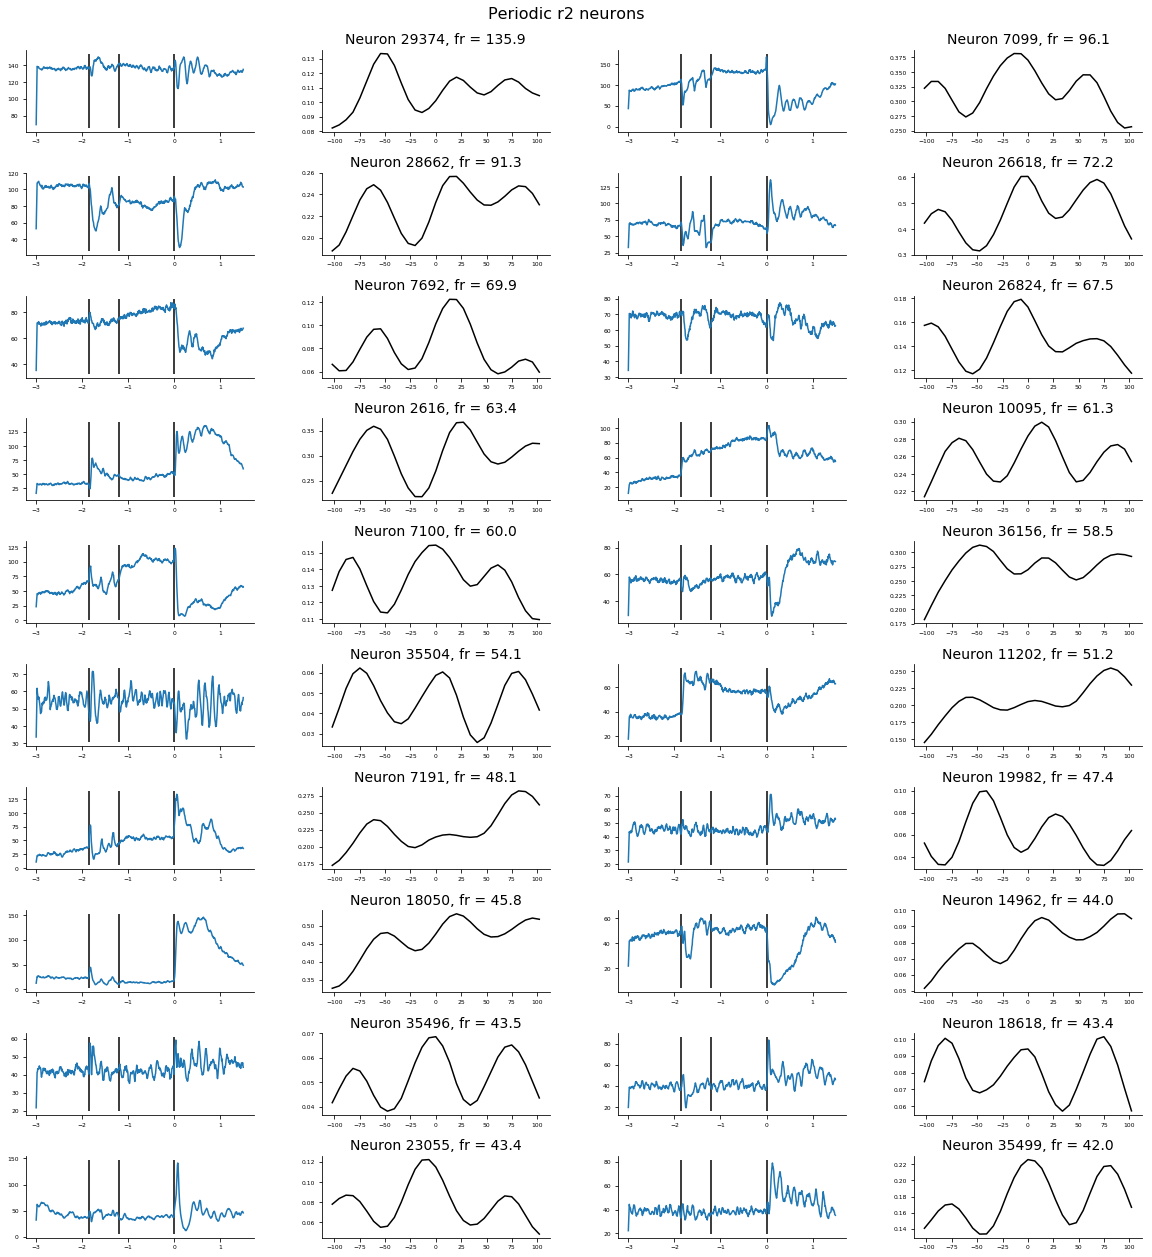

In [53]:
f,_ = plt.subplots(10,4, figsize = (20,20))
f.subplots_adjust(hspace = 0.5, wspace = 0.3, top = 0.95)
plt.suptitle('Periodic r2 neurons', fontsize = 16)

for i in range(20):
    ind = descending_fr_inds[i]
    plt.subplot(10,4,2*i+1)
    plt.plot(tt, periodic_neuron_fr[ind]['fr'].mean(axis = 1),)
    
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')


    plt.subplot(10,4,2*i+2)
    plt.plot(3.4*timeshifts, r2[:,ind], 'k')
    plt.title('Neuron %d, fr = %.1f'%(ind, fr[ind]), fontsize = 14)

plt.savefig('../figs/periodic_r2_neurons/20_highest_fr_periodic_neurons_mean_fr.png', bbox_inches = 'tight', dpi = 300)

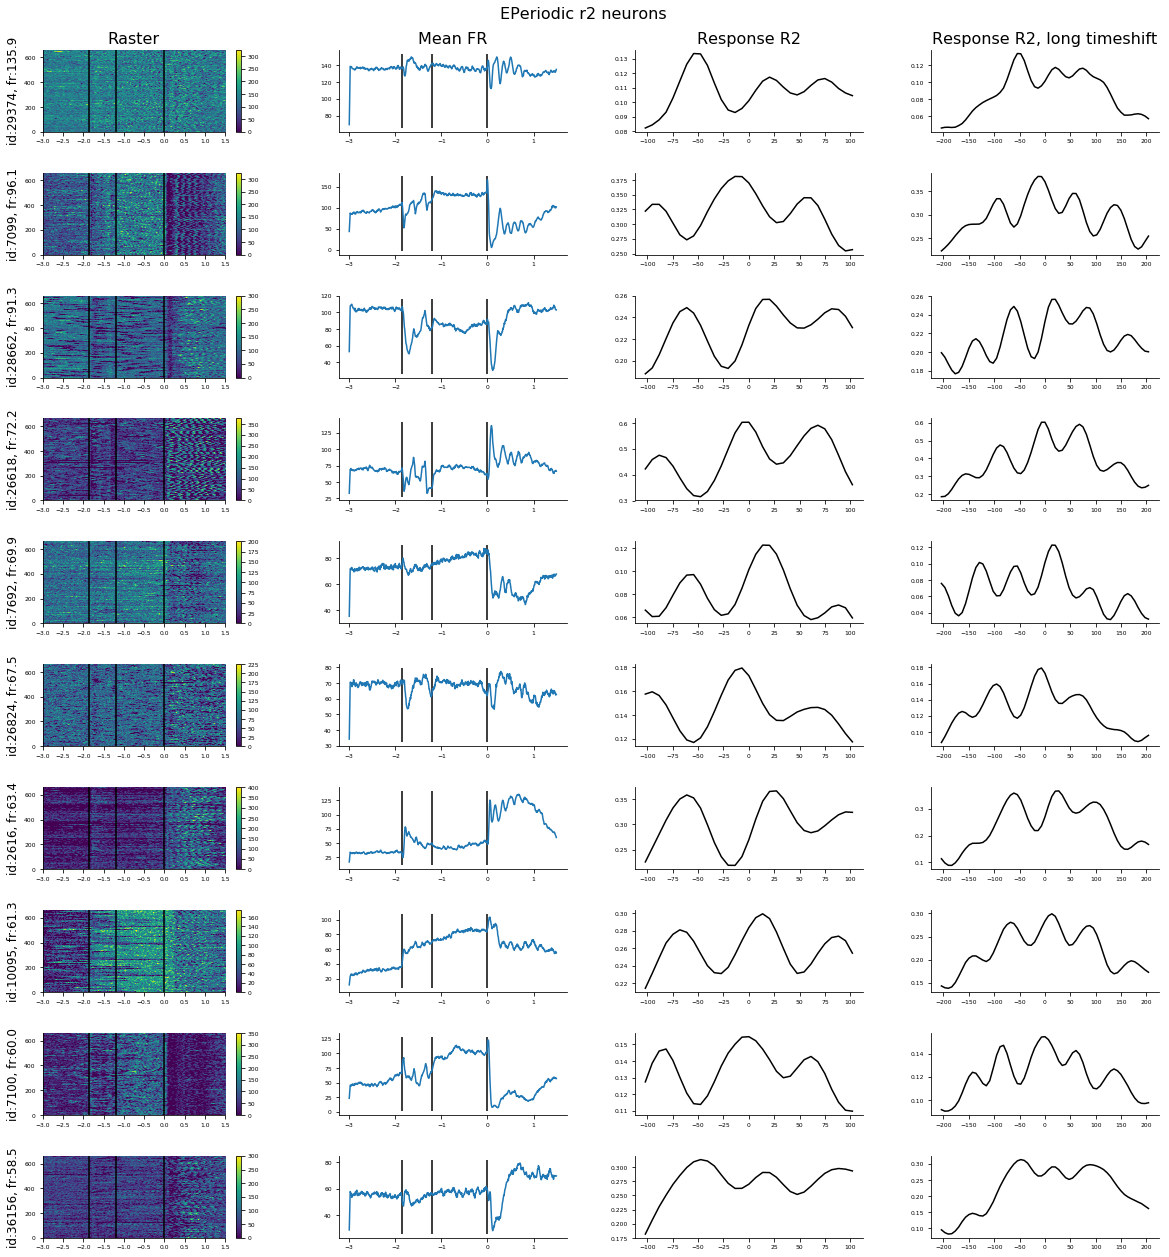

In [70]:
sess_array = np.array(r2_new['5_0']['session_name'])
sess_array_long = np.array(r2_long_raw['5_0']['session_name'])

f,_= plt.subplots(10,4, figsize = (20,20))
f.subplots_adjust(hspace = 0.5, wspace = 0.3, top = 0.95)
f.suptitle('EPeriodic r2 neurons', fontsize = 16)

for i in range(10):
    ind = descending_fr_inds[i]

    plt.subplot(10,4,4*i+1)
    if i == 0: plt.title('Raster', fontsize = 16)
    plt.imshow(periodic_neuron_fr[ind]['fr'].T, cmap = 'viridis', aspect = 'auto',
                extent = [tt[0], tt[-1], 0, periodic_neuron_fr[ind]['fr'].shape[0]])
    plt.colorbar()
    plt.vlines([-1.85,-1.2,0], 0, periodic_neuron_fr[ind]['fr'].shape[0], 'k')
    plt.ylabel('id:%d, fr:%.1f'%(ind, fr[ind]), fontsize = 12)

    plt.subplot(10,4,4*i+2)
    if i == 0: plt.title('Mean FR', fontsize = 16)
    plt.plot(tt, periodic_neuron_fr[ind]['fr'].mean(axis = 1),)
    plt.vlines([-1.85,-1.2,0], plt.ylim()[0], plt.ylim()[1], 'k')

    plt.subplot(10,4,4*i+3)
    if i == 0: plt.title('Response R2', fontsize = 16)
    plt.plot(3.4*timeshifts, r2[:,ind], 'k')

    plt.subplot(10,4,4*i+4)
    if i == 0: plt.title('Response R2, long timeshift', fontsize = 16)
    withinsess_ind = ind - np.min(np.where(r2_new['5_0']['session_name'] == r2_new['5_0']['session_name'][ind])[0])
    sess = r2_new['5_0']['session_name'][ind]
    long_ind = np.where(sess_array_long == sess)[0][withinsess_ind]

    plt.plot(3.4*timeshifts_long, r2_long[:,long_ind], 'k')

plt.savefig('../figs/periodic_r2_neurons/10_highest_fr_periodic_r2_allstats.png', bbox_inches = 'tight', dpi = 300)

## Longer timeshifts

In [19]:
f7.load_data(file_names = 'r2_embed_cv_timeshift_long.pkl')
thalamus_inds,_ = f7.get_thalamus_inds(n_threshold = 50, fr_threshold = 1, r2_threshold = 0.02, delta_r2 = 1.05)
cortex_inds,_ = f7.get_cortex_inds(n_threshold = 100)
medulla_inds,_ = f7.get_medulla_inds(n_threshold = 50)
midbrain_inds,_ = f7.get_midbrain_inds(n_threshold = 50)
best_times = f7.get_best_timeshift(timeshifts=np.arange(-60,62,2, dtype = int))

Central nucleus - mean=-4.36 ms, p=0.3700
Mediodorsal nucleus of thalamus - mean=-4.45 ms, p=0.0910
Paracentral nucleus - mean=-11.96 ms, p=0.0099
Posterior complex of the thalamus - mean=-9.04 ms, p=0.0000
Ventral anterior-lateral complex of the thalamus - mean=0.60 ms, p=0.8775
Ventral medial nucleus of the thalamus - mean=9.98 ms, p=0.0506
Ventral posterior complex of the thalamus - mean=-2.82 ms, p=0.2084
Medulla, sensory related - mean=7.79 ms, p=0.0272
Gigantocellular reticular nucleus - mean=34.84 ms, p=0.0000
Intermediate reticular nucleus - mean=19.52 ms, p=0.0000
Magnocellular reticular nucleus - mean=36.53 ms, p=0.0000
Parvicellular reticular nucleus - mean=6.41 ms, p=0.1504
Vestibular nuclei - mean=15.89 ms, p=0.0007
Substantia nigra, reticular part - mean=7.67 ms, p=0.2331
Midbrain reticular nucleus - mean=23.33 ms, p=0.0000
Superior colliculus, motor related - mean=19.89 ms, p=0.0000
Pretectal region - mean=0.44 ms, p=0.9030


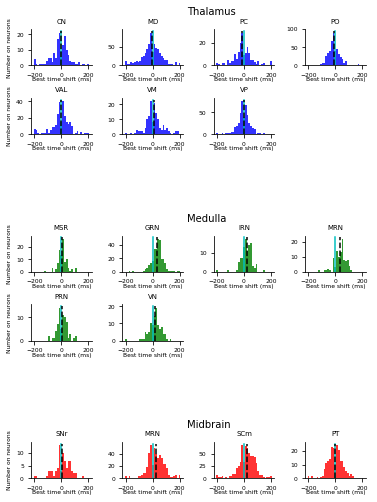

In [30]:
plt.rcParams['figure.figsize'][1] = style.fig_w_max * 7 / 6
plt.subplots(7,4)
plt.subplots_adjust(hspace = 0.9, wspace = 0.5)
#plt.subplots_adjust(top = 0.95)

filter_extreme_from_mean = True
plot_zero_line = True

extreme_inds = np.where((np.abs(best_times) > 200))[0]

for i_thalamus in range(len(thalamus_inds.keys())):
    plt.subplot(7,4, i_thalamus + 1)
    area = list(thalamus_inds.keys())[i_thalamus]
    _this_inds = thalamus_inds[area]
    plt.title(short_name_dict[area])
    
    plt.hist(best_times[_this_inds], bins = np.linspace(-205.4,205.4,32), color = 'blue', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f'%(area, mean, p_value))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.legend()
    if i_thalamus%4 == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best time shift (ms)', labelpad = -0.5)
    if i_thalamus == 1:
        plt.text(plt.xlim()[1] + 30, plt.ylim()[1]*1.4, 'Thalamus')

for ii in range(len(thalamus_inds.keys()),8):
    plt.subplot(7,4,ii + 1)
    plt.axis('off')

for i_medulla in range(len(medulla_inds.keys())):
    plt.subplot(7,4, 12 +  i_medulla + 1)
    area = list(medulla_inds.keys())[i_medulla]
    _this_inds = medulla_inds[area]
    plt.title(short_name_dict[area])
    plt.hist(best_times[_this_inds], bins = np.linspace(-205.4,205.4,32), color = 'green', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f'%(area, mean, p_value))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.ylabel('Number on neurons')
    if i_medulla%4 == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best time shift (ms)', labelpad = -0.5)
    if i_medulla == 1:
        plt.text(plt.xlim()[1] + 30, plt.ylim()[1]*1.4, 'Medulla')

for ii in range(len(medulla_inds.keys()),8):
    plt.subplot(7,4, 12 + ii + 1)
    plt.axis('off')

for i_midbrain in range(len(midbrain_inds.keys())):
    plt.subplot(7,4, 24 + i_midbrain + 1)
    area = list(midbrain_inds.keys())[i_midbrain]
    _this_inds = midbrain_inds[area]
    plt.title(short_name_dict[area])
    plt.hist(best_times[_this_inds], bins = np.linspace(-205.4,205.4,32), color = 'red', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        print('%s - mean=%.2f ms, p=%.4f'%(area, mean, p_value))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', label = 'zero')
    plt.plot([mean, mean], [a,b], 'k--', label = 'mean = %.2f'%mean)
    
    #plt.ylabel('Number on neurons')
    if i_midbrain == 0: plt.ylabel('Number on neurons')
    plt.xlabel('Best time shift (ms)', labelpad = -0.5)
    if i_midbrain == 1:
        plt.text(plt.xlim()[1] + 30, plt.ylim()[1]*1.4, 'Midbrain')


for ii in range(4):
    plt.subplot(7,4, 8 + ii + 1)
    plt.axis('off')
    plt.subplot(7,4, 20 + ii + 1)
    plt.axis('off')

plt.savefig(figfolder + 'timeshift_histgorams_v4.png', bbox_inches = 'tight', dpi = 300)


ALM - mean=8.81+/-2.19 ms, p=0.0003
Somatosensory areas - mean=-14.75+/-1.44 ms, p=0.0000
Somatomotor areas - mean=-10.30+/-3.80 ms, p=0.0292
Orbital area - mean=-39.72+/-3.30 ms, p=0.0000


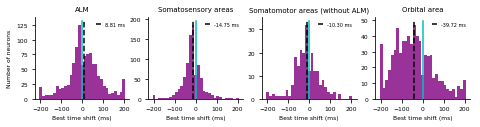

In [25]:
plt.subplots(1,4, figsize = (7.8,1.5))
n_comparisons = 4
extreme_inds = np.where((np.abs(best_times) > 200))[0]
filter_extreme_from_mean = True

for i_cortex in range(len(cortex_inds.keys())):
    plt.subplot(1,4, i_cortex + 1)
    area = list(cortex_inds.keys())[i_cortex]
    _this_inds = cortex_inds[area]
    titlestr = area
    if titlestr == 'Somatomotor areas':
        titlestr += ' (without ALM)'
    plt.title(titlestr)
    plt.hist(best_times[_this_inds], bins = np.linspace(-205.4,205.4,32), color = 'purple', alpha = 0.8)
    if filter_extreme_from_mean:
        mean_inds = np.setdiff1d(_this_inds, extreme_inds)
        t_statistic, p_value = stats.ttest_1samp(best_times[mean_inds], 0)
        mean = best_times[mean_inds].mean()
        sem = stats.sem(best_times[mean_inds])
        print('%s - mean=%.2f+/-%.2f ms, p=%.4f'%(area, mean, sem,p_value*n_comparisons))
    else:
        mean = best_times[_this_inds].mean()
    a,b = plt.ylim()
    plt.plot([mean, mean], [a,b], 'k--', label = '%.2f ms'%mean)
    if plot_zero_line: plt.plot([0,0], [a,b], 'c-', )
    plt.xlabel('Best time shift (ms)')
    if i_cortex == 0:
        plt.ylabel('Number of neurons')
    plt.legend()

plt.savefig('../figs/supplementary_figs/cortex_timeshift_histograms_v2.png', bbox_inches = 'tight', dpi = 300)